In [154]:
import numpy as np
import h5py
import json
from pathlib import Path
from typing import Union, Dict, Any, List
import scipy.sparse as sparse

class TensorStorage:
    @staticmethod
    def save_tensors(tensors: Dict[str, Union[np.ndarray, sparse.spmatrix, List[np.ndarray], List[sparse.spmatrix]]], 
                     filepath: str,
                     format: str = 'hdf5',
                     compress: bool = True,
                     metadata: Dict[str, Any] = None) -> None:
        filepath = Path(filepath)
        filepath.parent.mkdir(parents=True, exist_ok=True)
        
        if format == 'hdf5':
            with h5py.File(filepath, 'w') as f:
                for key, tensor in tensors.items():
                    if isinstance(tensor, list):
                        g = f.create_group(key)
                        g.attrs['is_list'] = True
                        for i, t in enumerate(tensor):
                            if sparse.issparse(t):
                                sg = g.create_group(f'item_{i}')
                                t = t.tocoo()
                                sg.create_dataset('data', data=t.data, compression='gzip' if compress else None)
                                sg.create_dataset('row', data=t.row, compression='gzip' if compress else None)
                                sg.create_dataset('col', data=t.col, compression='gzip' if compress else None)
                                sg.attrs['shape'] = t.shape
                                sg.attrs['format'] = 'sparse'
                            else:
                                g.create_dataset(f'item_{i}', data=t, compression='gzip' if compress else None)
                    else:
                        if sparse.issparse(tensor):
                            g = f.create_group(key)
                            tensor = tensor.tocoo()
                            g.create_dataset('data', data=tensor.data, compression='gzip' if compress else None)
                            g.create_dataset('row', data=tensor.row, compression='gzip' if compress else None)
                            g.create_dataset('col', data=tensor.col, compression='gzip' if compress else None)
                            g.attrs['shape'] = tensor.shape
                            g.attrs['format'] = 'sparse'
                        else:
                            f.create_dataset(key, data=tensor, compression='gzip' if compress else None)
                
                if metadata:
                    f.create_dataset('__metadata__', data=json.dumps(metadata))
        else:
            raise ValueError("Only HDF5 format supported for tensor lists")
    
    @staticmethod
    def load_tensors(filepath: str) -> tuple[Dict[str, Union[np.ndarray, sparse.spmatrix, List[Union[np.ndarray, sparse.spmatrix]]]], Dict[str, Any]]:
        filepath = Path(filepath)
        
        with h5py.File(filepath, 'r') as f:
            tensors = {}
            metadata = {}
            
            if '__metadata__' in f:
                metadata = json.loads(f['__metadata__'][()])
            
            for key in f.keys():
                if key == '__metadata__':
                    continue
                    
                if isinstance(f[key], h5py.Group):
                    if 'is_list' in f[key].attrs:
                        tensor_list = []
                        for i in range(len(f[key].keys())):
                            item = f[key][f'item_{i}']
                            if isinstance(item, h5py.Group):
                                tensor_list.append(sparse.coo_matrix(
                                    (item['data'][:], (item['row'][:], item['col'][:])),
                                    shape=item.attrs['shape']
                                ))
                            else:
                                tensor_list.append(item[:])
                        tensors[key] = tensor_list
                    else:
                        g = f[key]
                        tensors[key] = sparse.coo_matrix(
                            (g['data'][:], (g['row'][:], g['col'][:])),
                            shape=g.attrs['shape']
                        )
                else:
                    tensors[key] = f[key][:]
            
            return tensors, metadata

# Example usage


In [155]:
import math
import os
from math import log, cos, sin

In [156]:
def ln(x):
    return log(x, math.e)

In [157]:
def func(x):
    return ln(cos(x*x)) + sin(x)

In [158]:
def d_func(x):
    return -(sin(x * x) * 2 * x) / cos(x*x) + cos(x)

In [159]:
def h_func(x):
    return (func(x+1e-9) - func(x)) / 1e-9

In [160]:
d_func(5)

1.618926255678585

In [161]:
h_func(5)

1.6189263263299836

In [162]:
from collections import deque

def DFS(node):
    if not len(node.vars):
        return [node]
    ordered_vars = []
    for root in node.vars:
        ordered_vars += DFS(root)
    ordered_vars.append(node)
    return ordered_vars

def topological_DFS(node, visited=None, ordered_nodes=None, levels=None, level=None, key=lambda x: x.vars):
    if visited is None:
        visited = set()
    if ordered_nodes is None:
        ordered_nodes = []
    if levels is None:
        levels = []
    if level is None:
        level = 0

    if node not in visited:
        for root in key(node):
            topological_DFS(root, visited, ordered_nodes, levels, level + 1, key=key)
        ordered_nodes.append(node)
        levels.append(level)
        visited.add(node)
    return ordered_nodes, levels

def branchless_DFS(node, visited=None, ordered_nodes=None, levels=None, level=None, key=lambda x: x.vars):
    if visited is None:
        visited = set()
    if ordered_nodes is None:
        ordered_nodes = []
    if levels is None:
        levels = []
    if level is None:
        level = 0

    if node not in visited:
        key_roots = key(node)
        if node.op == "merge":
            key_roots = [key_roots[not node.kwarge["condition"]]]
        for root in key_roots:
            topological_DFS(root, visited, ordered_nodes, levels, level + 1, key=key)
        ordered_nodes.append(node)
        levels.append(level)
        visited.add(node)
    return ordered_nodes, levels

def BFS(node):
    """
    Perform BFS traversal on a graph represented by OpNode.

    Parameters:
    - root: The starting node (OpNode).

    Returns:
    - result: A list of node names in BFS order.
    """
    if node is None:
        return []
    
    visited = set()
    queue = deque([node])
    result = []

    while queue:
        current_node = queue.popleft()
        if current_node not in visited:
            # Process current node
            result.append(current_node)
            visited.add(current_node)

            # Add children to the queue
            for child in current_node.vars:
                if child not in visited:
                    queue.append(child)

    return result



In [207]:
import numpy as np

def im2col(input_tensor, kernal_shape, stride=1, padding=0):
    batch_size, img_height, img_width, num_channels = input_tensor.shape
    filter_height, filter_width = kernal_shape

    # Compute output dimensions
    out_height = (img_height + 2 * padding - filter_height) // stride + 1
    out_width = (img_width + 2 * padding - filter_width) // stride + 1
    # print("[im2col]", out_height, out_width)

    # Add padding to the input
    if padding > 0:
        input_tensor = np.pad(
            input_tensor,
            ((0, 0), (padding, padding), (padding, padding), (0, 0)),
            mode='constant',
            constant_values=0
        )

    # Create the im2col matrix
    col_matrix = np.zeros((batch_size, out_height, out_width, filter_height, filter_width, num_channels))

    # Fill the im2col matrix
    for h in range(filter_height):
        for w in range(filter_width):
            col_matrix[:, :, :, h, w, :] = input_tensor[
                :, 
                h:h + stride * out_height:stride, 
                w:w + stride * out_width:stride,
                :
            ]
    # Reshape to create the column matrix
    col_matrix = col_matrix.transpose(0, 1, 2, 5, 3, 4) 
    col_matrix = col_matrix.reshape(batch_size, out_height * out_width, -1) 
    return col_matrix

def col2im(col_matrix, input_shape, kernal_shape, stride=1, padding=0):
    if len(input_shape) == 4:
        batch_size, img_height, img_width, num_channels = input_shape
    elif len(input_shape) == 3:
        img_height, img_width, num_channels = input_shape
    else: raise Exception("col2im only accepts rank-3 or rank-4 tensors")
    filter_height, filter_width = kernal_shape

    if len(col_matrix.shape) != 3: raise Exception("col matrix needs to have an additional first dimension for the batch_size")
    batch_size, col_out_shape, channels_cross_ker = col_matrix.shape

    # Compute output dimensions
    out_height = (img_height + 2 * padding - filter_height) // stride + 1
    out_width = (img_width + 2 * padding - filter_width) // stride + 1

    # Initialize output tensor with zeros
    padded_height = img_height + 2 * padding
    padded_width = img_width + 2 * padding
    output = np.zeros((batch_size, padded_height, padded_width, num_channels))

    # Reshape col_matrix to extract patches
    # (batch_size, out_height, out_width, filter_height, filter_width, num_channels)
    col_matrix = col_matrix.reshape(batch_size, out_height, out_width, num_channels, filter_height, filter_width)
    col_matrix = col_matrix.transpose(0, 1, 2, 4, 5, 3) 

    # Accumulate gradients for each patch
    for h in range(filter_height):
        for w in range(filter_width):
            output[:, h:h + stride * out_height:stride, w:w + stride * out_width:stride, :] += col_matrix[:, :, :, h, w, :]

    # Remove padding if applied
    if padding > 0:
        output = output[:, padding:-padding, padding:-padding, :]

    return output


def im2col_pool(input_tensor, pool_shape, stride=2):
    N, H, W, C = input_tensor.shape
    pool_h, pool_w = pool_shape
    out_h = (H - pool_h) // stride + 1
    out_w = (W - pool_w) // stride + 1

    col = np.zeros((N, out_h, out_w, pool_h, pool_w, C))

    for y in range(pool_h):
        y_max = y + stride * out_h
        for x in range(pool_w):
            x_max = x + stride * out_w
            col[:, :, :, y, x, :] = input_tensor[:, y:y_max:stride, x:x_max:stride, :]

    col = col.transpose(0, 1, 2, 5, 3, 4).reshape(N, C * out_h * out_w, -1)
    return col

import numpy as np

def col2im_pool(col, input_shape, pool_shape, stride=2):
    N, H, W, C = input_shape
    pool_h, pool_w = pool_shape
    out_h = (H - pool_h) // stride + 1
    out_w = (W - pool_w) // stride + 1
    
    col = col.reshape(N, out_h, out_w, C, pool_h, pool_w).transpose(0, 1, 2, 4, 5, 3)
    
    img = np.zeros((N, H, W, C))
    
    for y in range(pool_h):
        y_max = y + stride * out_h
        for x in range(pool_w):
            x_max = x + stride * out_w
            img[:, y:y_max:stride, x:x_max:stride, :] += col[:, :, :, y, x, :]
    
    return img



In [179]:
import uuid
import numpy as np

from collections.abc import Iterable

def get_broadcast_shape(shape1, shape2):
    len_diff = abs(len(shape1) - len(shape2))
    if len(shape1) > len(shape2):
        shape2 = (1,) * len_diff + shape2
    else:
        shape1 = (1,) * len_diff + shape1

    broadcast_shape = []
    for dim1, dim2 in zip(shape1, shape2):
        if dim1 == dim2 or dim1 == 1 or dim2 == 1:
            broadcast_shape.append(max(dim1, dim2))
        else:
            raise ValueError(f"Shapes {shape1} and {shape2} are not broadcastable")
    
    return tuple(broadcast_shape)


def eval_reduce_semi_broadcast_shape(og_shape, axis):
    if axis is None: return tuple([1]*len(og_shape))
    if type(axis) not in [tuple, list]: axis=(axis,)
    shape_ls = list(og_shape) 
    for ax in axis: shape_ls[ax] = 1
    semi_broadcasted_shape = tuple(shape_ls)
    return semi_broadcasted_shape

def infer_matmul_broadcast_shape(unbroadcasted_shape, output_shape): # einsum is too hard
    matmul_dims = unbroadcasted_shape[-2:]
    batch_dims = output_shape[:-2]

    broadcast_shape = batch_dims + matmul_dims
    
    return broadcast_shape

def matmul_batch_axes_match(input_shape, output_shape): # einsum is too hard
    return input_shape[:-2] == output_shape[:-2]

def infer_reduction_axis(shape, reduced_shape):
    len_diff = len(shape) - len(reduced_shape)
    if len_diff > 0:
        reduced_shape = (1,) * len_diff + reduced_shape
    
    # Identify the axes where the reduction occurred
    reduction_axes = [i for i, (r_dim, red_dim) in enumerate(zip(shape, reduced_shape)) if red_dim == 1 and r_dim != 1]
    
    return tuple(reduction_axes)

def broadcast_adjoint(adjoint, wrt, this):
    if type(wrt.val) != np.ndarray or wrt.val.size < this.val.size:
        reduce_axes = infer_reduction_axis(
            shape=this.val.shape,
            reduced_shape=wrt.val.shape
        )
        adjoint = adjoint.sum(axis=reduce_axes)
    return adjoint

def reverse_pad(array, pad_width):
    """
    Reverse the effect of np.pad on a numpy array.
    
    Parameters:
    array (ndarray): The padded numpy array.
    pad_width (sequence of tuple): Number of values padded to the edges of each axis.
    
    Returns:
    ndarray: The original array before padding.
    """
    slices = []
    for (before, after) in pad_width:
        start = before
        end = None if after == 0 else -after
        slices.append(slice(start, end))
    
    return array[tuple(slices)]

class OpNode:
    NUMERIC_TYPES = [
        int, float, np.bool_, np.int8,
        np.int16, np.int32, np.int64, np.uint8,
        np.uint16, np.uint32, np.uint64, np.float16,
        np.float32, np.float64, np.complex64, np.complex128,
    ]
    CONSTANT_TYPES = NUMERIC_TYPES + [np.ndarray]

    def __init__(self, op, prefix="", constant=None, is_param=False, **kwargs):
        if op == "const" and constant is None:
            raise Exception("Const node needs to be assigned a value !!")
        self._id = str(uuid.uuid4()) # never to be changed
        self.name = f"{op}_{self._id[:5]}"
        self.prefix = prefix
        self.op = op
        self.vars = []
        self.leafs = []
        self.val = constant
        self.adjoint = None if op != "const" else 0
        self.kwargs = kwargs
        self.is_param = is_param
        self.inputs = []
        self.outputs = []
        self.frozen = False
        self._cycle = None
        if "axis" in self.kwargs and type(self.kwargs["axis"]) not in [list, tuple]:
            self.kwargs["axis"] = (self.kwargs["axis"])

    def set_name(self, name):
        self.name = name
        return self

    def set_graph_inputs(self, inputs: list):
        self.inputs = inputs
        return self
    
    def append_graph_inputs(self, inputs: list):
        self.inputs = self.inputs + inputs
        return self
    
    def set_graph_outputs(self, outputs: list):
        self.outputs = outputs
        return self

    def substitute(self, val):
        if self.op == "const": raise Exception("You cannot assign a new value to constant node")
        self.val = val
        return self

    def __call__(self, *args):
        if len(args):
            self.vars = []
            for i, arg in enumerate(args):
                op_arg = arg
                if type(arg) in OpNode.CONSTANT_TYPES:
                    op_arg = OpNode("const", constant=arg)
                self.vars.append(op_arg)
                if self not in op_arg.leafs: op_arg.leafs.append(self)
        return self
    
    @property
    def cycle(self): return self._cycle

    @cycle.setter
    def cycle(self, cycle):
        if cycle.op != "var" or cycle.is_param: raise Exception("Only none parameter variables can be used as a cycle nodes")
        self._cycle = cycle

    @staticmethod
    def _add(node1, node2):
        op_node1 = node1
        if type(node1) in OpNode.CONSTANT_TYPES:
            op_node1 = OpNode("const", constant=node1)
        op_node2 = node2
        if type(node2) in OpNode.CONSTANT_TYPES:
            op_node2 = OpNode("const", constant=node2)
        if op_node1 == op_node2 and node1 == op_node2:
            return OpNode("*")(OpNode("const", constant=2), op_node2)
        res = OpNode("+")(op_node1, op_node2)
        return res
    
    def __add__(self, other): return OpNode._add(self, other)
    def __radd__(self, other): return OpNode._add(other, self)

    @staticmethod
    def _mul(node1, node2):
        op_node1 = node1
        if type(node1) in OpNode.CONSTANT_TYPES:
            op_node1 = OpNode("const", constant=node1)
        op_node2 = node2
        if type(node2) in OpNode.CONSTANT_TYPES:
            op_node2 = OpNode("const", constant=node2)
        if op_node1 == op_node2 and node1 == op_node2:
            return OpNode("**")(op_node2, OpNode("const", constant=2))
        res = OpNode("*")(op_node1, op_node2)
        return res
    
    def __mul__(self, other): return OpNode._mul(self, other)
    def __rmul__(self, other): return OpNode._mul(other, self)

    @staticmethod
    def _matmul(node1, node2):
        op_node1 = node1
        if type(node1) in OpNode.CONSTANT_TYPES:
            op_node1 = OpNode("const", constant=node1)
        op_node2 = node2
        if type(node2) in OpNode.CONSTANT_TYPES:
            op_node2 = OpNode("const", constant=node2)
        res = OpNode("@")(op_node1, op_node2)
        return res
    
    def __matmul__(self, other): return OpNode._matmul(self, other)
    def __rmatmul__(self, other): return OpNode._matmul(other, self)

    @staticmethod
    def _sub(node1, node2):
        op_node1 = node1
        if type(node1) in OpNode.CONSTANT_TYPES:
            op_node1 = OpNode("const", constant=node1)
        op_node2 = node2
        if type(node2) in OpNode.CONSTANT_TYPES:
            op_node2 = OpNode("const", constant=node2)
        if op_node1 == op_node2 and node1 == op_node2:
            return OpNode("const", constant=0)
        res = OpNode("-")(op_node1, op_node2)
        return res
    
    def __sub__(self, other): return OpNode._sub(self, other)
    def __rsub__(self, other): return OpNode._sub(other, self)
    
    @staticmethod
    def _truediv(node1, node2):
        op_node1 = node1
        if type(node1) in OpNode.CONSTANT_TYPES:
            op_node1 = OpNode("const", constant=node1)
        op_node2 = node2
        if type(node2) in OpNode.CONSTANT_TYPES:
            op_node2 = OpNode("const", constant=node2)
        if op_node1 == op_node2 and node1 == op_node2:
            return OpNode("const", constant=1)
        res = OpNode("/")(op_node1, op_node2)
        return res
    
    def __truediv__(self, other): return OpNode._truediv(self, other)
    def __rtruediv__(self, other): return OpNode._truediv(other, self)
    
    @staticmethod
    def _pow(node1, node2):
        op_node1 = node1
        if type(node1) in OpNode.CONSTANT_TYPES:
            op_node1 = OpNode("const", constant=node1)
        op_node2 = node2
        if type(node2) in OpNode.CONSTANT_TYPES:
            op_node2 = OpNode("const", constant=node2)
        res = OpNode("**")(op_node1, op_node2)
        return res

    def __pow__(self, other): return OpNode._pow(self, other)
    def __rpow__(self, other): return OpNode._pow(other, self)

    def __neg__(self):
        return OpNode("neg")(self)

    def equals(self, other, **kwargs): return OpNode(op="==", **kwargs)(self, other)
    def sum(self, axis, keepdims, **kwargs): return OpNode(op="+", axis=axis, keepdims=keepdims, **kwargs)(self)
    def prod(self, axis, keepdims, **kwargs): return OpNode(op="*", axis=axis, keepdims=keepdims, **kwargs)(self)
    def mean(self, axis, keepdims, **kwargs): return OpNode(op="mean", axis=axis, keepdims=keepdims, **kwargs)(self)
    def max(self, axis, keepdims, **kwargs): return OpNode(op="max", axis=axis, keepdims=keepdims, **kwargs)(self)
    def min(self, axis, keepdims, **kwargs): return OpNode(op="min", axis=axis, keepdims=keepdims, **kwargs)(self)
    def dot(self, other, **kwargs): return OpNode(op="@")(self, other, **kwargs)
    def transpose(self, axes, **kwargs): return OpNode(op="T", axes=axes, **kwargs)(self)
    def T(self, axes, **kwargs): return OpNode(op="T", axes=axes, **kwargs)(self)
    def reshape(self, shape, **kwargs): return OpNode(op="reshape", shape=shape, **kwargs)(self)
    def pad(self, pad_width, **kwargs): return OpNode(op="pad", pad_width=pad_width, **kwargs)(self)

    @property
    def shape(self):
        try: return self.val.shape
        except Exception as e: print(e)

    def partial_derivative(self, with_respect_to):
        if not len(self.vars): return None
        if with_respect_to not in self.vars: return 0
        if with_respect_to.op == "const": 
            if type(with_respect_to.val) == np.ndarray: return np.zeros(with_respect_to.val.shape)
            return 0

        # if not len(self.leafs): return 1
        match(self.op):
            case "const":
                return 0
            case "neg":
                if type(self.val) == np.ndarray:
                    return -1 * np.ones(self.val.shape)
                return -1
            case "=="|"equals"|">="|"gte"|">"|"gt"|"<="|"lte"|"<"|"lt":
                if type(self.val) == np.ndarray:
                    # partial = np.zeros(with_respect_to.val.shape) if type(with_respect_to.val) == np.ndarray else 0 # MIGHT COME BACK
                    partial = np.zeros(self.val.shape)
                    return partial
                return 0
            case "concat" | "concatenate":
                axis = self.kwargs.get("axis", -1)
                x_indices = [x_idx for x_idx, var in enumerate(self.vars) if var == with_respect_to]
                cumusum = [0] + list(np.cumsum([var.val.shape[axis] for var in self.vars]))
                partial = np.zeros(self.val.shape)
                ranges = [(cumusum[idx], cumusum[idx+1]) for idx in x_indices]
                for rng in ranges:
                    slices = [slice(None)] * self.val.ndim
                    slices[axis] = slice(*rng)
                    slices = tuple(slices)
                    partial[slices] = 1
                return partial
            case "mean" | "avg": # vars[2] should be reduced or vars[1] should be broadcasted
                if len(self.vars) == 1 and type(self.vars[0].val) == np.ndarray:
                    axis = self.kwargs.get("axis", None)
                    if axis is None: size = self.vars[0].val.size
                    else:
                        if not isinstance(axis, tuple): axis = (axis,)
                        size = np.prod([self.vars[0].val.shape[ax] for ax in axis])
                    return np.ones(self.vars[0].val.shape) / size
                count = 0
                for var in self.vars:
                    if var == with_respect_to:
                        count += 1
                if type(self.val) == np.ndarray:
                    partial = np.ones(with_respect_to.val.shape) * count / len(self.vars) if type(with_respect_to.val) == np.ndarray else count / len(self.vars)
                    return partial
                return count / len(self.vars)
            case "+" | "sum":
                if len(self.vars) == 1 and type(self.vars[0].val) == np.ndarray:
                    return np.ones(self.vars[0].val.shape)
                count = 0
                for var in self.vars:
                    if var == with_respect_to:
                        count += 1
                if type(self.val) == np.ndarray:
                    # partial = np.ones(with_respect_to.val.shape) * count if type(with_respect_to.val) == np.ndarray else count # MIGHT COME BACK
                    partial = np.ones(self.val.shape) * count
                    return partial
                return count
            case "-":
                if len(self.vars) != 2: raise Exception("minus op only accepts two inputs")
                scalar = 1
                if self.vars[0] == self.vars[1]: scalar = 0
                elif self.vars[0] == with_respect_to: scalar = 1
                else: scalar = -1
                if type(self.val) == np.ndarray:
                    # partial = np.ones(with_respect_to.val.shape) * scalar if type(with_respect_to.val) == np.ndarray else scalar # MIGHT COME BACK
                    partial = np.ones(self.val.shape) * scalar
                    return partial
                return scalar
            case "*" | "prod":
                if len(self.vars) == 1 and type(self.vars[0].val) == np.ndarray:
                    semi_broadcasted_shape = eval_reduce_semi_broadcast_shape(
                        og_shape=self.vars[0].val.shape,
                        axis=self.kwargs["axis"],
                    )
                    return self.val.reshape(semi_broadcasted_shape) / np.where(self.vars[0].val == 0, 1, self.vars[0].val)
                count = 0
                for var in self.vars:
                    if var == with_respect_to:
                        count += 1
                partial = count * self.val / np.where(with_respect_to.val == 0, 1, with_respect_to.val)
                return partial
            case "@" | "matmul":
                if type(self.vars[0].val) == np.ndarray and type(self.vars[1].val) == np.ndarray:
                    if self.vars[0] == with_respect_to:
                        ndim = self.vars[1].val.ndim
                        dims = list(range(ndim))
                        dims[-2], dims[-1] = dims[-1], dims[-2]
                        return self.vars[1].val.transpose(dims)
                    else:
                        ndim = self.vars[0].val.ndim
                        dims = list(range(ndim))
                        dims[-2], dims[-1] = dims[-1], dims[-2]
                        return self.vars[0].val.transpose(dims)
                else: raise Exception("matmul op only accepts two numpy array inputs")
            case "/":
                if len(self.vars) != 2: raise Exception("divide op only accepts two inputs")
                if self.vars[0] == self.vars[1]: ## and self.vars[0] == with_respect_to
                    if type(self.val) == np.ndarray:
                        # partial = np.zeros(with_respect_to.val.shape) if type(with_respect_to.val) == np.ndarray else 0 # MIGHT COME BACK
                        partial = np.zeros(self.val.shape)
                        return partial
                    return 0
                if self.vars[0] == with_respect_to:
                    partial = 1 / self.vars[1].val
                    return partial
                partial = -1 * self.vars[0].val / (with_respect_to.val ** 2)
                return partial
            case "**":
                if len(self.vars) != 2: raise Exception("pow op only accepts two inputs")

                base, exponent = self.vars

                # Case when both base and exponent are the same variable
                if base == exponent:  # This case is unusual but let's handle it
                    if base == with_respect_to:
                        return self.val * (1 + np.log(with_respect_to.val))
                    raise Exception("Unexpected case: both base and exponent are the same but not the target variable")

                # Case when differentiating with respect to the base
                if base == with_respect_to:
                    return exponent.val * (base.val ** (exponent.val - 1))

                # Case when differentiating with respect to the exponent
                if exponent == with_respect_to:
                    return self.val * np.log(base.val)

                raise Exception("with_respect_to not found in inputs")
            case "max" | "min":
                self_val = self.val
                if len(self.vars) == 1 and type(self.vars[0].val) == np.ndarray:
                # if type(with_respect_to.val) == np.ndarray:
                    semi_broadcasted_shape = eval_reduce_semi_broadcast_shape(
                        og_shape=self.vars[0].val.shape,
                        axis=self.kwargs["axis"] if "axis" in self.kwargs else None,
                    )
                    self_val = self_val.reshape(semi_broadcasted_shape)
                partial = with_respect_to.val == self_val
                return partial
            # case "min": 
            #     self_val = self.val
            #     if len(self.vars) == 1 and type(self.vars[0].val) == np.ndarray:
            #         semi_broadcasted_shape = eval_reduce_semi_broadcast_shape(
            #             og_shape=self.vars[0].val.shape,
            #             axis=self.kwargs["axis"] if "axis" in self.kwargs else None,
            #         )
            #         self_val = self_val.reshape(semi_broadcasted_shape)
            #     return with_respect_to.val == self_val
            case "transpose" | "T":
                if type(with_respect_to.val) == np.ndarray:
                    return np.ones(with_respect_to.val.shape)
                return 1
            case "reshape":
                if type(with_respect_to.val) == np.ndarray:
                    return np.ones(with_respect_to.val.shape)
                return 1
            case "pad":
                if type(with_respect_to.val) == np.ndarray:
                    return np.ones(with_respect_to.val.shape)
                return 1
            case "im2col" | "col2im" | "im2col_pool" | "col2im_pool": return np.ones(self.val.shape)
            case "ln": return 1 / (with_respect_to.val + 1e-5) ## and self.vars[0] == with_respect_to
            case "log10": return 1 / (with_respect_to.val * np.log(10) + 1e-5)
            case "log2": return 1 / (with_respect_to.val * np.log(2) + 1e-5)
            case "cos": return -np.sin(with_respect_to.val) ## and self.vars[0] == with_respect_to
            case "sin": return np.cos(with_respect_to.val) ## and self.vars[0] == with_respect_to
            case "tan": return 1 / (np.cos(with_respect_to.val) ** 2 + 1e-5) ## and self.vars[0] == with_respect_to
            case "cosh": return np.sinh(with_respect_to.val) ## and self.vars[0] == with_respect_to
            case "sinh": return np.cosh(with_respect_to.val) ## and self.vars[0] == with_respect_to
            case "tanh": return 1 / (np.cosh(with_respect_to.val) ** 2 + 1e-5) ## and self.vars[0] == with_respect_to
            case "sqrt": return 1 / (2 * self.val + 1e-5) ## and self.vars[0] == with_respect_to
            case "exp": return self.val
            case "merge": return np.ones(with_respect_to.val.shape) if type(with_respect_to.val) == np.ndarray else 1
            case _:
                return self.vars[0].val

    def compute_adjoint(self):
        if not len(self.leafs):
            # print("skipped !!")
            # if self.adjoint is None or self.adjoint == "false":
            if self.adjoint is None:
                if type(self.val) == np.ndarray:
                    self.adjoint = np.ones(self.val.shape)
                    return
                self.adjoint = 1
            return
        # if self.adjoint is None or self.adjoint == "false":
        if self.adjoint is None or self.op == "const": 
            # print(self, "HERE", self.leafs)
            self.adjoint = 0
        all_false_or_merge = True
        for lef in self.leafs:
            if (lef.op != "merge" and (type(lef.adjoint) == np.ndarray or lef.adjoint != "false")) or\
                (
                    lef.op == "merge" and\
                    (
                        (lef.kwargs["condition"] and lef.vars[0] == self) or\
                        (not lef.kwargs["condition"] and lef.vars[1] == self)
                    )
                ):
                all_false_or_merge = False
        if all_false_or_merge: 
            # print("------------------------->", all_false_or_merge)
            self.adjoint = "false"
            return
        # print("not false:", self.adjoint)
        # print("==="*100)
        # print("OG-OP:", self)
        # print("OG-OP.val.shape:", self, "::", self.val.shape if type(self.val) == np.ndarray else (1,))
        # print("BACKWARD.Leafs.ops:", self.leafs)
        # print("BACKWARD.Leafs.val.sum:", [np.sum(l.val) for l in self.leafs])
        # print("BACKWARD.Leafs.val.shape:", [l.val.shape if type(l.val) == np.ndarray else (1,) for l in self.leafs])
        # print("BACKWARD.Leafs.val:", [l.val for l in self.leafs])
        # print("BACKWARD.Leafs.adjoint.sum:", [np.sum(l.adjoint) for l in self.leafs])
        # print("BACKWARD.Leafs.adjoint.shape:", [l.adjoint.shape if type(l.adjoint) == np.ndarray else (1,) for l in self.leafs])
        # print("BACKWARD.Leafs.adjoint:", [l.adjoint for l in self.leafs])
        # print("BACKWARD.Leafs.ops:", [l.op for l in self.leafs])

        for leaf in self.leafs:
            # print("i just got it here LEAF:", leaf)
            if leaf.adjoint is not None and (type(leaf.adjoint) == np.ndarray or leaf.adjoint != "false"):
                match (leaf.op):
                    case "slice" | "[]":
                        input_shape = self.val.shape
                        self_adjoint = np.zeros(input_shape)
                        indices = self.kwargs["indices"]
                        self_adjoint[indices] = leaf.adjoint
                        self.adjoint += self_adjoint
                    case "merge":
                        # print("CASE MERGE "*5, leaf.kwargs["condition"], leaf.vars[0], leaf.vars[1], self)
                        if  (
                                (leaf.kwargs["condition"] and leaf.vars[0] == self) or\
                                (not leaf.kwargs["condition"] and leaf.vars[1] == self)
                            ):
                            partial = leaf.partial_derivative(self)
                            # print("="*50)
                            # print(partial, leaf.adjoint)
                            self.adjoint += leaf.adjoint * partial
                    case "@" | "matmul":
                        # print("BEFORE:", leaf.adjoint)
                        # print("i just got to the condition LEAF:", leaf.val.shape)
                        if type(leaf.adjoint) != np.ndarray or not bool(leaf.adjoint.shape): 
                            leaf.adjoint = np.ones(leaf.val.shape)
                        partial_derivative = leaf.partial_derivative(self)
                        # print("HERE:", partial_derivative.shape, "AFTER:", leaf.adjoint.shape)
                        if self == leaf.vars[0]: self_adjoint = leaf.adjoint @ partial_derivative
                        else: self_adjoint = partial_derivative @ leaf.adjoint
                        if self.val.ndim != leaf.val.ndim or matmul_batch_axes_match(self.val.shape, leaf.val.shape):
                            reduce_axes = infer_reduction_axis(leaf.val.shape, self.val.shape)
                            self.adjoint += self_adjoint.sum(axis=reduce_axes)
                    case "sum"|"prod"|"+"|"-"|"/"|"*"|"max"|"min"|"mean"|"avg":
                        partial_derivative = leaf.partial_derivative(self)
                        if len(leaf.vars) == 1 :
                            if type(self.val) == np.ndarray: 
                                reshaped_leaf_adjoint = leaf.adjoint
                                # infered_axes = infer_reduction_axis(self.val.shape, leaf.val.shape)
                                keepdims_shape = eval_reduce_semi_broadcast_shape(
                                    og_shape=self.val.shape,
                                    axis=leaf.kwargs.get("axis", None),
                                )
                                if type(leaf.adjoint) == np.ndarray and leaf.adjoint.shape != keepdims_shape:
                                    reshaped_leaf_adjoint = leaf.adjoint.reshape(keepdims_shape)
                                self_adjoint = reshaped_leaf_adjoint * partial_derivative
                                self_adjoint = np.broadcast_to(self_adjoint, self.val.shape)
                            else:
                                self_adjoint = leaf.adjoint * partial_derivative
                            
                        if len(leaf.vars) == 2:
                            if type(leaf.adjoint) == np.ndarray and (type(self.val) != np.ndarray or self.val.shape != leaf.adjoint.shape):
                                axes = infer_reduction_axis(
                                    leaf.adjoint.shape,
                                    self.val.shape if type(self.val) == np.ndarray else len(leaf.adjoint.shape)*[1]
                                )
                                self_adjoint = leaf.adjoint * partial_derivative
                                self_adjoint = self_adjoint.sum(axis=axes, keepdims=True)
                            else:
                                self_adjoint = leaf.adjoint * partial_derivative

                        self.adjoint += self_adjoint
                    case "transpose" | "T": self.adjoint += leaf.adjoint.transpose(leaf.kwargs["axes"]) * leaf.partial_derivative(self)
                    case "reshape": self.adjoint += leaf.adjoint.reshape(self.val.shape) * leaf.partial_derivative(self)
                    case "pad": self.adjoint += reverse_pad(self.val, leaf.kwargs["pad_width"]) * leaf.partial_derivative(self)
                    case "concat" | "concatenate":
                        axis = leaf.kwargs.get("axis", -1)
                        x_indices = [x_idx for x_idx, var in enumerate(leaf.vars) if var == self]
                        cumusum = np.cumsum([var.val.shape[axis] for var in leaf.vars])[:-1]
                        split_adjoint = np.split(leaf.adjoint, cumusum, axis=axis)
                        sum_adjoint = np.zeros(self.val.shape)
                        for i in x_indices:
                            sum_adjoint += split_adjoint[i]
                        self.adjoint += sum_adjoint * leaf.partial_derivative(self)
                    case "im2col":
                        self_adjoint = leaf.adjoint * leaf.partial_derivative(self)
                        self_adjoint = col2im(
                            col_matrix=self_adjoint,
                            input_shape=self.val.shape,
                            kernal_shape=leaf.kwargs["kernal_shape"],
                            stride=leaf.kwargs["stride"],
                            padding=leaf.kwargs["padding"]
                        )
                        self.adjoint += self_adjoint
                    case "col2im":
                        self_adjoint = leaf.adjoint * leaf.partial_derivative(self)
                        self_adjoint = im2col(
                            input_tensor=self_adjoint,
                            kernal_shape=leaf.kwargs["kernal_shape"],
                            stride=leaf.kwargs["stride"],
                            padding=leaf.kwargs["padding"]
                        )
                        self.adjoint += self_adjoint
                    case "im2col_pool":
                        self_adjoint = leaf.adjoint * leaf.partial_derivative(self)
                        self_adjoint = col2im_pool(
                            col=self_adjoint,
                            input_shape=self.val.shape,
                            pool_shape=leaf.kwargs["pool_shape"],
                            stride=leaf.kwargs["stride"]
                        )
                        self.adjoint += self_adjoint
                    case "col2im_pool":
                        self_adjoint = leaf.adjoint * leaf.partial_derivative(self)
                        self_adjoint = im2col_pool(
                            input_tensor=self_adjoint,
                            pool_shape=leaf.kwargs["pool_shape"],
                            stride=leaf.kwargs["stride"]
                        )
                        self.adjoint += self_adjoint
                    case _:
                        # if "[ReLU]max" in self.name:
                        #     print("==IMPORTANT=="*30)
                        #     print("_", leaf.adjoint)
                        #     print("==IMPORTANT=="*30) 
                        self.adjoint += leaf.adjoint * leaf.partial_derivative(self)

        if type(self.val) == np.ndarray and type(self.adjoint) == np.ndarray and self.val.size == self.adjoint.size:
            self.adjoint = self.adjoint.reshape(self.val.shape)
        
        if type(self.val) != np.ndarray and type(self.adjoint) == np.ndarray and self.adjoint.size == 1:
            self.adjoint = self.adjoint.reshape((-1))[0]


    def compute(self):
        if not len(self.vars): return
        
        match(self.op):
            case "const": return
            case "neg":
                if len(self.vars) > 1: raise Exception("negation op only takes one input")
                self.val = -1 * self.vars[0].val
            case "==" | "equals":
                if len(self.vars) == 2:
                    if type(self.vars[0].val) == type(self.vars[1].val):
                        if type(self.vars[0].val) == np.ndarray and self.vars[0].val.shape != self.vars[1].val.shape:
                            raise Exception("inputs have mismatching shapes")
                        self.val = self.vars[0].val == self.vars[1].val
                    else: raise Exception("inputs have mismatching types")
                else: raise Exception("equals op only accepts two inputs")
            case ">=" | "gte":
                if len(self.vars) == 2:
                    if type(self.vars[0].val) == type(self.vars[1].val):
                        if type(self.vars[0].val) == np.ndarray and self.vars[0].val.shape != self.vars[1].val.shape:
                            raise Exception("inputs have mismatching shapes")
                        self.val = self.vars[0].val >= self.vars[1].val
                    else: raise Exception("inputs have mismatching types")
                else: raise Exception("gte op only accepts two inputs")
            case ">" | "gt":
                if len(self.vars) == 2:
                    if type(self.vars[0].val) == type(self.vars[1].val):
                        if type(self.vars[0].val) == np.ndarray and self.vars[0].val.shape != self.vars[1].val.shape:
                            raise Exception("inputs have mismatching shapes")
                        self.val = self.vars[0].val > self.vars[1].val
                    else: raise Exception("inputs have mismatching types")
                else: raise Exception("gte op only accepts two inputs")
            case "<=" | "lte":
                if len(self.vars) == 2:
                    if type(self.vars[0].val) == type(self.vars[1].val):
                        if type(self.vars[0].val) == np.ndarray and self.vars[0].val.shape != self.vars[1].val.shape:
                            raise Exception("inputs have mismatching shapes")
                        self.val = self.vars[0].val <= self.vars[1].val
                    else: raise Exception("inputs have mismatching types")
                else: raise Exception("gte op only accepts two inputs")
            case "<" | "lt":
                if len(self.vars) == 2:
                    if type(self.vars[0].val) == type(self.vars[1].val):
                        if type(self.vars[0].val) == np.ndarray and self.vars[0].val.shape != self.vars[1].val.shape:
                            raise Exception("inputs have mismatching shapes")
                        self.val = self.vars[0].val < self.vars[1].val
                    else: raise Exception("inputs have mismatching types")
                else: raise Exception("gte op only accepts two inputs")
            case "concat" | "concatenate":
                if len(self.vars) <= 1: raise Exception("concat requires at least 2 or more inputs")
                axis = self.kwargs.get("axis", -1)
                if type(axis) != int: raise Exception("concat only accepts one axis")
                self.val = np.concatenate((var.val for var in self.vars ), axis=axis)
            case "mean" | "avg":
                if len(self.vars) == 1:
                    if type(self.vars[0].val) == np.ndarray:
                        self.val = self.vars[0].val.mean(**self.kwargs)
                    else:
                        self.val = self.vars[0].val
                else:
                    summ = 0
                    for root in self.vars:
                        summ = summ + root.val
                    self.val = summ / len(self.vars)
            case "+" | "sum":
                if len(self.vars) == 1:
                    if type(self.vars[0].val) == np.ndarray:
                        self.val = self.vars[0].val.sum(**self.kwargs)
                    else:
                        self.val = self.vars[0].val
                else:
                    summ = 0
                    for root in self.vars:
                        summ = summ + root.val
                    self.val = summ
            case "-":
                if len(self.vars) == 2:
                    if self.vars[0] == self.vars[1]: self.val = 0
                    else: self.val = self.vars[0].val - self.vars[1].val
                else: raise Exception("minus op only accepts two inputs")
            case "*" | "prod":
                if len(self.vars) == 1:
                    if type(self.vars[0].val) == np.ndarray:
                        self.val = self.vars[0].val.prod(**self.kwargs)
                    else:
                        self.val = self.vars[0].val
                else:
                    prod = 1
                    for root in self.vars:
                        prod = prod * root.val
                    self.val = prod
            case "@" | "matmul":
                if len(self.vars) == 2:
                    if type(self.vars[0].val) == type(self.vars[1].val):
                        if type(self.vars[0].val) == np.ndarray: 
                            # print('@ @', 
                            #     self.vars[0].op, self.vars[0].val.shape,
                            #     self.vars[1].op, self.vars[1].val.shape
                            # )
                            self.val = self.vars[0].val @ self.vars[1].val
                            # print('@ @', self.leafs, self.val.shape, self.val)
                        else: self.val = self.vars[0].val * self.vars[1].val
                    else: raise Exception("mismatching input types in matmul")
                else: raise Exception("matmul op only accepts two inputs")
            case "/":
                if len(self.vars) == 2:
                    if self.vars[0] == self.vars[1]: self.val = 1
                    else: self.val = self.vars[0].val / self.vars[1].val
                else: raise Exception("divide op only accepts two inputs")
            case "**":
                if len(self.vars) == 2:
                    base = self.vars[0].val
                    power = self.vars[1].val
                    self.val = base ** power
                else: raise Exception("pow op only accepts two inputs")
            case "max":
                if len(self.vars) == 1:
                    if type(self.vars[0].val) == np.ndarray:
                        self.val = self.vars[0].val.max(**self.kwargs)
                    else:
                        self.val = self.vars[0].val
                else:
                    if any(map(lambda var: type(var.val) == np.ndarray, self.vars)):
                        if len(self.vars) > 2: raise Exception("You can only compare two ndarrays using max op !")
                        self.val = np.maximum(self.vars[0].val, self.vars[1].val)
                    else: self.val = max(list(map(lambda var: var.val, self.vars)))
            case "min":
                if len(self.vars) == 1:
                    if type(self.vars[0].val) == np.ndarray:
                        self.val = self.vars[0].val.min(**self.kwargs)
                    else:
                        self.val = self.vars[0].val
                else:
                    if any(map(lambda var: type(var.val) == np.ndarray, self.vars)):
                        if len(self.vars) > 2: raise Exception("You can only compare two ndarrays using min op !")
                        self.val = np.minimum(self.vars[0].val, self.vars[1].val)
                    else: self.val = min(list(map(lambda var: var.val, self.vars)))
            
            case "transpose" | "T":
                if len(self.vars) != 1: raise Exception("transpose operation only takes one tensor input")
                if type(self.vars[0].val) == np.ndarray:
                    if "axes" in self.kwargs:
                        # print("before:", self.vars[0].val.shape)
                        self.val = self.vars[0].val.transpose(self.kwargs["axes"])
                        # print("after:", self.val.shape)
                    else:
                        self.val = self.vars[0].val.T
                else:
                    self.val = self.vars[0].val
            case "reshape":
                # print("before reshape:", self.vars[0].val.shape)
                if len(self.vars) != 1: raise Exception("reshape operation only takes one tensor input")
                if type(self.vars[0].val) == np.ndarray:
                    if "shape" in self.kwargs:
                        # print("YO ?")
                        self.val = self.vars[0].val.reshape(self.kwargs["shape"])
                    else:
                        raise Exception("reshape function requires a tuple as an arg")
                else:
                    self.val = self.vars[0].val
                # print("after reshape:", self.val.shape, "axes:", self.kwargs["shape"])
            case "pad":
                if len(self.vars) != 1: raise Exception("pad operation only takes one tensor input")
                if "pad_width" not in self.kwargs: raise Exception("pad operation requires argument 'pad_width'")
                pad_width = self.kwargs["pad_width"]
                inp = self.vars[0].val
                if type(inp) == np.ndarray:
                    self.val = np.pad(inp, pad_width)
                else:
                    broad = np.broadcast_to(inp, [1]*len(pad_width))
                    self.val = np.pad(broad, pad_width)
            case "im2col":
                if len(self.vars) != 1: raise Exception("im2col operation only takes one tensor input")
                if not ("kernal_shape" in self.kwargs and "stride" in self.kwargs and "padding" in self.kwargs):
                    raise Exception("im2col requires all of these arguments ['kernal_shape', 'stride', 'padding']")
                self.val = im2col(
                    input_tensor=self.vars[0].val, 
                    kernal_shape=self.kwargs["kernal_shape"],
                    stride=self.kwargs["stride"],
                    padding=self.kwargs["padding"]
                )
            case "col2im":
                if len(self.vars) != 1: raise Exception("col2im operation only takes one matrix input")
                if not ("kernal_shape" in self.kwargs and "stride" in self.kwargs and "padding" in self.kwargs):
                    raise Exception("col2im requires all of these arguments ['input_shape', 'kernal_shape', 'stride', 'padding']")
                self.val = col2im(
                    col_matrix=self.vars[0].val,
                    input_shape=self.kwargs["input_shape"],
                    kernal_shape=self.kwargs["kernal_shape"],
                    stride=self.kwargs["stride"],
                    padding=self.kwargs["padding"]
                )
            case "im2col_pool":
                if len(self.vars) != 1: raise Exception("im2col_pool operation only takes one tensor input")
                if not ("kernal_shape" in self.kwargs and "stride" in self.kwargs and "padding" in self.kwargs):
                    raise Exception("im2col_pool requires all of these arguments ['pool_shape', 'stride']")
                self.val = im2col_pool(
                    input_tensor=self.vars[0].val, 
                    pool_shape=self.kwargs["pool_shape"],
                    stride=self.kwargs["stride"]
                )
            case "col2im_pool":
                if len(self.vars) != 1: raise Exception("col2im_pool operation only takes one matrix input")
                if not ("kernal_shape" in self.kwargs and "stride" in self.kwargs and "padding" in self.kwargs):
                    raise Exception("col2im_pool requires all of these arguments ['input_shape', 'pool_shape', 'stride']")
                self.val = col2im_pool(
                    col=self.vars[0].val,
                    input_shape=self.kwargs["input_shape"],
                    pool_shape=self.kwargs["pool_shape"],
                    stride=self.kwargs["stride"]
                )
            case "ln": self.val = np.log(self.vars[0].val, **self.kwargs)
            case "log10": self.val = np.log10(self.vars[0].val, **self.kwargs)
            case "log2": self.val = np.log2(self.vars[0].val, **self.kwargs)
            case "cos": self.val = np.cos(self.vars[0].val, **self.kwargs)
            case "sin": self.val = np.sin(self.vars[0].val, **self.kwargs)
            case "tan": self.val = np.tan(self.vars[0].val, **self.kwargs)
            case "cosh": self.val = np.cosh(self.vars[0].val, **self.kwargs)
            case "sinh": self.val = np.sinh(self.vars[0].val, **self.kwargs)
            case "tanh": self.val = np.tanh(self.vars[0].val, **self.kwargs)
            case "sqrt": self.val = np.sqrt(self.vars[0].val, **self.kwargs)
            case "exp": self.val = np.exp(self.vars[0].val, **self.kwargs)
            # case "branch":
            #     if len(self.vars) != 1: raise Exception("branch op accepts only one arg")
            #     self.val = self.vars[0].val
            case "merge":
                if len(self.vars) != 2: raise Exception("merge accepts two args, first for when the condition is true, second for false")
                if "condition" not in self.kwargs: raise Exception("no condition was provided to merge node !!")
                self.val = self.vars[not self.kwargs["condition"]].val
            case "slice" | "[]":
                if len(self.vars) != 1: raise Exception("slice op only excepts one input node")
                indices = self.kwargs["indices"]
                self.val = self.vars[0].val[indices]
            case _:
                raise Exception("Invalid Operation !!")
        return self.val

    def graph_forward(self, input_values=[], local_inputs_only=False):
        if not len(self.inputs): raise Exception("Cannont compute result of graph without setting the graph input nodes")
        if len(self.inputs) != len(input_values): raise Exception("input length mismatch")
        for input_node, input_value in zip(self.inputs, input_values):
            input_node.substitute(input_value)
        ordered_operations, _ = topological_DFS(self)
        # print(ordered_operations)
        ordered_operations = [node for node in ordered_operations if node.op != "const"]
        self.ordered_operations = ordered_operations
        if local_inputs_only:
            limited_operations = []
            num_input_found = 0
            for op in ordered_operations[::-1]:
                if op in self.inputs:
                    num_input_found += 1
                    if num_input_found < len(self.inputs): continue
                    else: break
                limited_operations.append(op)
            ordered_operations = reversed(limited_operations)
        for op in ordered_operations:
            if op.op != "var" and op.op != "const":
                op.compute()
                if op._cycle is not None:
                    op._cycle.val = op.val
            print("-->", op, op.val.shape)

        return self.val
    
    def graph_backward(self, y_adjoint=None):
        if y_adjoint is not None: self.adjoint = y_adjoint
        # ordered_operations, _ = branchless_DFS(self)
        ordered_operations, _ = topological_DFS(self)
        ordered_operations = [node for node in ordered_operations if node.op != "const"]
        self.ordered_operations = ordered_operations
        if any(map(lambda node: node.val is None, ordered_operations)):
            raise Exception("Forward pass didnt fill in all of the values of the nodes")
        
        trainable_params = []
        gradients = []
        # print(ordered_operations)
        for op in reversed(ordered_operations):
            # if op.op == "var" and not op.is_param: continue
            if op != self or y_adjoint is None:
                op.adjoint = None
                op.compute_adjoint()
                # print("backward>",op, ":", op.adjoint, op.is_param)
            if op.is_param and op.op == "var" and not op.frozen and not op.op == "const":
                trainable_params.append(op)
                gradients.append(op.adjoint)

        return trainable_params, gradients
    
    def graph_freeze(self, local_inputs_only=True):
        if local_inputs_only and not len(self.inputs): raise Exception("Cannont freeze local inputs, without defining the local inputs of the graph")
        ordered_operations, _ = topological_DFS(self)
        ordered_operations = [node for node in ordered_operations if node.op != "const"]
        if local_inputs_only:
            limited_operations = []
            num_input_found = 0
            for op in ordered_operations[::-1]:
                if op in self.inputs:
                    num_input_found += 1
                    if num_input_found < len(self.inputs): continue
                    else: break
                limited_operations.append(op)
            ordered_operations = reversed(limited_operations)

        for op in ordered_operations:
            if op.is_param and op.op == "var":
                op.frozen = True

        return self
    
    def graph_unfreeze(self, local_inputs_only=True):
        if local_inputs_only and not len(self.inputs): raise Exception("Cannont freeze local inputs, without defining the local inputs of the graph")
        ordered_operations, _ = topological_DFS(self)
        ordered_operations = [node for node in ordered_operations if node.op != "const"]
        if local_inputs_only:
            limited_operations = []
            num_input_found = 0
            for op in ordered_operations[::-1]:
                if op in self.inputs:
                    num_input_found += 1
                    if num_input_found < len(self.inputs): continue
                    else: break
                limited_operations.append(op)
            ordered_operations = reversed(limited_operations)

        for op in ordered_operations:
            if op.is_param and op.op == "var":
                op.frozen = False

        return self

    def reset_gradients(self):
        ordered_operations, _ = topological_DFS(self)
        for op in ordered_operations:
            op.adjoint = None
            
    # def backpropagate(self, callback):
    #     ordered_operations, _ = topological_DFS(self)
    #     if any(map(lambda node: node.val is None, ordered_operations)):
    #         raise Exception("Forward pass didnt fill in all of the values of the nodes")
        
    #     for op in reversed(ordered_operations):
    #         if not op.is_param or op.op != "var" or op.frozen: continue
    #         callback(op)
    #         # print(f"[{op}] adjoint:", op.adjoint)
    #         # print("---------------------")
        
    def __hash__(self):
        return hash((self._id, self.prefix, self.name))

    def __eq__(self, other):
        return isinstance(other, OpNode) and self._id == other._id and self.op == other.op and self.name == other.name and self.prefix == other.prefix
    
    def __repr__(self) -> str:
        lim = len(self.op) + 6
        name = self.name[:lim]
        if lim < len(self.name):
            name += "..."
        is_param = ""
        if self.op == "var" and self.is_param:
            is_param = "{param}"
        return f'{self.prefix}["{name}"].{self.op}' + is_param

In [180]:
def create_padding_mask(seq):
    mask = (seq == 0).astype(np.float32)
    return mask[:, np.newaxis, np.newaxis, :] * -1e9
    
seq = np.array([[1, 2, 3, 0, 0], [3, 4, 0, 0, 0]])  # Example sequences
padding_mask = create_padding_mask(seq)
print("Padding Mask:\n", padding_mask)


Padding Mask:
 [[[[-0.e+00 -0.e+00 -0.e+00 -1.e+09 -1.e+09]]]


 [[[-0.e+00 -0.e+00 -1.e+09 -1.e+09 -1.e+09]]]]


In [181]:
def create_look_ahead_mask(size):
    mask = np.triu(np.ones((size, size)), k=1)
    return mask * -1e9
    
size = 5  # Example size
look_ahead_mask = create_look_ahead_mask(size)
print("Look-Ahead Mask:\n", look_ahead_mask)


Look-Ahead Mask:
 [[-0.e+00 -1.e+09 -1.e+09 -1.e+09 -1.e+09]
 [-0.e+00 -0.e+00 -1.e+09 -1.e+09 -1.e+09]
 [-0.e+00 -0.e+00 -0.e+00 -1.e+09 -1.e+09]
 [-0.e+00 -0.e+00 -0.e+00 -0.e+00 -1.e+09]
 [-0.e+00 -0.e+00 -0.e+00 -0.e+00 -0.e+00]]


In [ ]:
from typing import Union, List, Tuple, Any
from abc import ABC, abstractmethod
import numpy as np

TYPES = Union[
    OpNode, int, float, np.bool_, np.int8,
    np.int16, np.int32, np.int64, np.uint8,
    np.uint16, np.uint32, np.uint64, np.float16,
    np.float32, np.float64, np.complex64, np.complex128,
    np.ndarray
]

def var(initial_val=None, is_param=False, prefix=""):
    x = OpNode(op="var", is_param=is_param, prefix=prefix)
    if initial_val is not None:
        x.substitute(initial_val)
    return x

def param(initial_val=None, prefix=""):
    x = OpNode(op="var", is_param=True, prefix=prefix)
    if initial_val is not None:
        x.substitute(initial_val)
    return x

def const(val):
    return OpNode(op="const", constant=val)

def variance_graph(x_node: OpNode, axis=None, keepdims=False, prefix=""):
    """
    Operation graph for the variance of x_node.
    
    Parameters:
    - x_node: Input node.
    - axis: Axis or axes along which to compute the variance.
    - keepdims: If True, retains reduced dimensions with size 1.
    
    Returns:
    - variance op graph: Computed variance of x_node.
    """
    mean = x_node.mean(axis=axis, keepdims=True, prefix=prefix)
    # squared_diff = (x_node - mean) ** 2
    squared_diff = OpNode(op="**", prefix=prefix)(OpNode(op="-", prefix=prefix)(x_node, mean), 2)
    variance = squared_diff.mean(axis=axis, keepdims=keepdims, prefix=prefix)
    return variance

# (b, c, w, h)
# (k, c, k_w, k_h)
# (b, k, (w - k_w + 2 * p) / s, (h - k_h + 2 * p) / s)

def shapes_equal_ignoring_axis(shape1, shape2, axis):
    """
    Check if two shapes are equal ignoring the specified axis.
    
    Parameters:
    shape1 (tuple): The shape of the first array.
    shape2 (tuple): The shape of the second array.
    axis (int): The axis to ignore for comparison.
    
    Returns:
    bool: True if the shapes are equal ignoring the specified axis, False otherwise.
    """
    # Create copies of the shapes
    shape1_modified = list(shape1)
    shape2_modified = list(shape2)
    
    # Remove the dimension at the specified axis
    del shape1_modified[axis]
    del shape2_modified[axis]
    
    # Compare the modified shapes
    return shape1_modified == shape2_modified

def softmax_graph(x_node: OpNode, axis=-1):
    exps = OpNode(op="exp")(x_node - x_node.max(axis=axis, keepdims=True))
    soft = exps / exps.sum(axis=axis, keepdims=True) + 1e-9
    return soft

import inspect

def is_json_serializable(obj):
    try:
        json.dumps(obj)
        return True
    except (TypeError, OverflowError):
        return False

def serialize_iterables_in_dict(root: dict):
    copy = {}
    for k, v in root.items():
        if type(v) == dict:
            copy[k] = serialize_iterables_in_dict(v)
        else:
            if type(v) in [tuple, set, map, filter]:
                copy[k] = list(v)
            else:
                copy[k] = v
    return copy

def _init_weights(shape, method, name):
    fan_in, fan_out = shape[0], shape[1]
    
    if method == 'xavier_uniform':
        # Xavier/Glorot uniform initialization
        limit = np.sqrt(6.0 / (fan_in + fan_out))
        weights = np.random.uniform(-limit, limit, shape)
        
    elif method == 'xavier_normal':
        # Xavier/Glorot normal initialization
        std = np.sqrt(2.0 / (fan_in + fan_out))
        weights = np.random.normal(0, std, shape)
        
    elif method == 'kaiming_uniform':
        # He/Kaiming uniform initialization
        limit = np.sqrt(6.0 / fan_in)
        weights = np.random.uniform(-limit, limit, shape)
        
    elif method == 'kaiming_normal':
        # He/Kaiming normal initialization
        std = np.sqrt(2.0 / fan_in)
        weights = np.random.normal(0, std, shape)
        
    elif method == 'transformer':
        # Transformer-style initialization (used in "Attention is All You Need")
        if name in ['query', 'key', 'value']:
            # Initialize Q, K, V with smaller weights
            std = np.sqrt(1.0 / shape[0])
        else:  # output
            # Initialize output projection with Xavier/Glorot
            std = np.sqrt(2.0 / (fan_in + fan_out))
        weights = np.random.normal(0, std, shape)
        
    else:
        raise ValueError(f"Unknown initialization method: {method}")
        
    return weights

import tensorflow as tf
import numpy as np


class ReLU:
    def __init__(self):
        pass

    def __call__(self, X_node: OpNode, prefix=""):
        self.y_node = OpNode(op="max", prefix="ReLU")(0, X_node).set_graph_inputs(inputs=[X_node])
        return self.y_node

    def forward(self, X):
        return self.y_node.graph_forward(input_values=[X])
    
    def backward(self, y_grad=None):
        # return self.output_node.graph_backward(y_adjoint=y_grad)
        pass
    
class Sigmoid:
    def __init__(self):
        super().__init__()

    def __call__(self, X_node: OpNode, prefix=""):
        self.y_node = 1 / (1 + OpNode(op="exp", prefix=prefix)(-X_node))
        self.y_node.set_graph_inputs(inputs=[X_node])
        return self.y_node
    
    def forward(self, X):
        return self.y_node.graph_forward(input_values=[X])
    
    def backward(self, y_grad=None):
        # return self.output_node.graph_backward(y_adjoint=y_grad)
        pass

class Softmax:
    def __init__(self, axis=-1):
        super().__init__()
        self.axis = axis

    def __call__(self, X_node: OpNode, prefix=""):
        exp_node = OpNode(op="exp", prefix="softmax")(X_node - OpNode(op="max", axis=self.axis, keepdims=True, prefix="softmax")(X_node))
        self.y_node = exp_node / OpNode(op="sum", axis=self.axis, keepdims=True, prefix=prefix)(exp_node)
        self.y_node.set_graph_inputs(inputs=[X_node])
        return self.y_node
    
    def forward(self, X):
        return self.y_node.graph_forward(input_values=[X])
    
    def backward(self, y_grad=None):
        # return self.output_node.graph_backward(y_adjoint=y_grad)
        pass


def softmax(x):
    # Shift the input by the max value for numerical stability
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    # Normalize along the last axis
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

def activation_factory(class_name):
    instance = None
    match(class_name.lower()):
        case "relu": instance = ReLU()
        case "sigmoid": instance = Sigmoid()
        case "softmax": instance = Softmax()
    return instance
    

class Layer(ABC):

    layers_name_map = {}

    def __init__(self, shape=None, name=""):
        self.name = name
        self.model_layer_key = None
        self.shape: tuple = shape
        self.output_node: OpNode = None
        self.previous_layers = []
        self._trainable = True

    def __init_subclass__(cls, **kwargs):
        super().__init_subclass__(**kwargs)
        if cls.__name__.lower() not in Layer.layers_name_map:
            Layer.layers_name_map[cls.__name__.lower()] = cls

    @property
    def trainable(self):
        return self._trainable
    
    @trainable.setter
    def trainable(self, trainable):
        self._trainable = trainable
        if self._trainable:
            self.output_node.graph_unfreeze(local_inputs_only=True)
        else:
            self.output_node.graph_freeze(local_inputs_only=True)

    def get_output_shape_(self): return self.shape
    
    def get_output_node_(self): return self.output_node

    @abstractmethod
    def __call__(self): pass

    @abstractmethod
    def forward(self): pass

    @abstractmethod
    def backward(self, y_grad=None): pass

    def parameter_count(self):
        count = 0
        for attr_value in vars(self).values():
            if type(attr_value) == OpNode and attr_value.op == "var" and attr_value.is_param:
                count += attr_value.val.size if type(attr_value.val) == np.ndarray else 1
        return count

    def get_params(self):
        params = []
        for attr_value in vars(self).values():
            if type(attr_value) == OpNode and attr_value.op == "var" and attr_value.is_param:
                params.append(attr_value.val)
        return params
    
    def set_params(self, *params: Union[*OpNode.CONSTANT_TYPES]):
        if self.output_node is None: raise Exception("Layer has to be functionally called on previous layer before its params can be set manually [example: Layer(*args)(prev_layer)]")
        param_names = []
        prev_vals = []
        for attr_key, attr_value in vars(self).items():
            if type(attr_value) == OpNode and attr_value.op == "var" and attr_value.is_param:
                param_names.append(attr_key)
                prev_vals.append(attr_value)
        if len(param_names) != len(params): raise Exception(f"number of params provided doesnt fit the number required which is: {len(param_names)}, set any param to None if u wish to keep it as default")
        for i, (param_name, prev_val, param) in enumerate(zip(param_names, prev_vals, params)):
            if param is not None:
                if type(prev_val.val) != type(param): raise Exception(f"param '{param_name}' at position: [{i}] requries type == {type(prev_val.val)} but got {type(param)} instead")
                if type(param) == np.ndarray and (prev_val.val.shape != param.shape): raise Exception(f"param '{param_name}' at position: [{i}] requries shape == {prev_val.val.shape} but got {param.shape} instead")
                prev_val.substitute(param)
        return self

    def json_serialize_init_args(self):
        constructor_signature = inspect.signature(self.__class__.__init__)
        parameter_names = list(constructor_signature.parameters.keys())[1:]
        constructor_attributes = {attr: getattr(self, attr) for attr in parameter_names}
        constructor_attributes = serialize_iterables_in_dict(constructor_attributes)
        if "activation" in constructor_attributes:
            constructor_attributes["activation"] = constructor_attributes["activation"].__class__.__name__.lower()
        if not is_json_serializable(constructor_attributes): raise Exception(f"All constructor args in ({self.__class__}) need to be json serializable, for when the model architecture is saved as json")
        return constructor_attributes

    def get_layer_class_name(self):
        return self.__class__.__name__

    def __repr__(self):
        if_activation = ""
        if hasattr(self, 'activation'):
            if_activation = " | " + str(type(self.activation))
        return "Layer: " + self.get_layer_class_name() + " | " + str(self.get_output_shape_()) + if_activation

class Input(Layer):
    def __init__(self, shape, name=""):
        super().__init__(shape=shape, name=name)
        self.output_node = var(prefix="INPUT")
    
    def __call__(self): 
        return self

    def forward(self, X): return X 

    def backward(self, y_grad=None): pass

class Add(Layer):
    def __init__(self, name="", axis=-1):
        super().__init__(name=name)
        self.axis = axis

    def __call__(self, *entries: Layer):
        self.previous_layers = list(entries)
        if len(entries) <= 1: raise Exception("Add layer requires at least two layers as inputs")
        some_shape = entries[0].get_output_shape_()
        if any(map(lambda l: l.get_output_shape_() != some_shape, entries)):
            raise Exception("Layer shape mismatch, all layers must have the same shape for Add layer")
        self.shape = some_shape
        self.X_nodes = [entry.get_output_node_() for entry in entries]
        self.output_node = OpNode(op="sum", axis=self.axis)(*self.X_nodes)
        self.output_node.set_graph_inputs(inputs=self.X_nodes)
        return self
    
    def forward(self, X):
        return self.output_node.graph_forward(input_values=[X])
    
    def backward(self, y_grad=None):
        # return self.output_node.graph_backward(y_adjoint=y_grad)
        pass

class Reshape(Layer):
    def __init__(self, shape, name=""):
        super().__init__(shape=shape, name=name)
 
    def __call__(self, entry: Layer): 
        self.previous_layers = [entry]
        self.X_nodes = entry.get_output_node_()
        self.output_node = self.X_nodes.reshape((-1, *self.shape))
        self.output_node.set_graph_inputs(inputs=self.X_nodes)
        return self

    def forward(self, X):
        return self.output_node.graph_forward(input_values=[X])
    
    def backward(self, y_grad=None):
        # return self.output_node.graph_backward(y_adjoint=y_grad)
        pass

class Flatten(Layer):
    def __init__(self, name=""):
        super().__init__(name=name)

    def __call__(self, entry: Layer):
        self.previous_layers = [entry]
        input_shape = entry.get_output_shape_()
        self.X_nodes = entry.get_output_node_()
        self.shape = (np.prod(input_shape),)
        self.output_node = self.X_nodes.reshape((-1, *self.shape))
        self.output_node.set_graph_inputs(inputs=self.X_nodes)
        return self
    
    def forward(self, X):
        return self.output_node.graph_forward(input_values=[X])
    
    def backward(self, y_grad=None):
        # return self.output_node.graph_backward(y_adjoint=y_grad)
        pass

class Concatenate(Layer):
    def __init__(self, name="", axis=-1):
        super().__init__(name=name)
        self.axis = axis

    def __call__(self, *entries: Layer):
        self.previous_layers = list(entries)
        if len(entries) <= 1: raise Exception("Concatenate layer requires at least two layers as inputs")
        some_ndim = len(entries[0].get_output_shape_())
        if any(map(lambda l: len(l.get_output_shape_()) != some_ndim, entries)):
            raise Exception("Layer ndim mismatch, all layers must have the same ndim for Concatenate layer")
        self.X_nodes = [entry.get_output_node_() for entry in entries]
        self.output_node = OpNode(op="concat", axis=self.axis)(*self.X_nodes)
        self.output_node.set_graph_inputs(inputs=self.X_nodes)
        return self
    
    def forward(self, X):
        return self.output_node.graph_forward(input_values=[X])
    
    def backward(self, y_grad=None):
        # return self.output_node.graph_backward(y_adjoint=y_grad)
        pass

class Dense(Layer):
    def __init__(self, units, activation = None, name=""):
        super().__init__(name=name)
        self.units = units
        self.activation = activation
        if type(activation) == str:
            self.activation = activation_factory(activation.lower())

    def __call__(self, entry: Layer):
        self.previous_layers = [entry]
        input_shape = entry.get_output_shape_()
        ndim = len(input_shape)
        self.shape = (*input_shape[:-1], self.units)
        w_shape = input_shape[-1], self.units
        print(w_shape)
        self.W = np.random.randn(input_shape[-1], self.units) * np.sqrt(2. / np.prod(self.shape))
        # W = np.random.uniform(
        #     low=-np.sqrt(1 / self.shape[0]), high=np.sqrt(1 / self.shape[0]), size=(self.shape[0], self.shape[1])
        # )
        self.b = np.zeros((1, self.shape[-1]))
        self.X_node = entry.get_output_node_()
        self.W_node = param(initial_val=self.W, prefix=self.name+".W")
        self.b_node = param(initial_val=self.b, prefix=self.name+".b")
        self.z_node = (self.X_node @ self.W_node) + self.b_node
        self.output_node = self.z_node
        if self.activation is not None:
            self.output_node = self.activation(self.z_node, prefix=self.name)
        self.output_node.set_graph_inputs(inputs=[self.X_node])
        return self
    
    def forward(self, X):
        return self.output_node.graph_forward(input_values=[X], local_inputs_only=True)

    def backward(self, y_grad=None):
        # return self.output_node.graph_backward(y_adjoint=y_grad)
        pass

class Dropout(Layer):
    def __init__(self, drop_prob=0.5, name=""):
        """
        Initialize Dropout layer.
        
        Parameters:
        -----------
        drop_prob : float, optional
            Probability of dropping a neuron (default: 0.5)
        """
        super().__init__(name=name)
        self.drop_prob = drop_prob
        # Seed for reproducibility of dropout mask
        self.seed = np.random.randint(0, 1000)
        self._training_mode = True

    @property
    def training_mode(self):
        return self._training_mode
    
    @training_mode.setter
    def training_mode(self, training_mode):
        self._training_mode = training_mode
        self.output_node.kwargs["condition"] = training_mode
        return self

    def __call__(self, entry: Layer):
        """
        Create Dropout computation graph.
        
        Parameters:
        -----------
        entry : Layer
            Input layer

        Returns:
        --------
        Layer
            Dropout Layer
        """
        self.previous_layers = [entry]
        input_shape = entry.get_output_shape_()
        self.X_node = entry.get_output_node_()
        self.shape = input_shape
        def training_graph():
            np.random.seed(self.seed)
            mask = const(val=(np.random.rand(*self.shape) > self.drop_prob).astype(float))
            return self.X_node * mask / (1 - self.drop_prob)
        
        def inference_graph():
            return self.X_node
        
        self.output_node = OpNode(op="merge", condition=self._training_mode, prefix=self.name)(
            training_graph(), 
            inference_graph()
        )
        self.output_node.set_graph_inputs(inputs=[self.X_node])
        return self
    
    def forward(self, X):
        return self.output_node.graph_forward(input_values=[X], local_inputs_only=True)
    
    def backward(self, y_grad=None):
        # return self.output_node.graph_backward(y_adjoint=y_grad)
        pass

class BatchNorm(Layer):
    def __init__(self, epsilon=1e-3, momentum=0.99, name=""):
        """
        Initialize BatchNorm layer for OpNode-based computation.
        
        Parameters:
        -----------
        num_features : int
            Number of features/channels to normalize
        epsilon : float, optional
            Small constant to prevent division by zero (default: 1e-3)
        momentum : float, optional
            Momentum for running mean and variance calculation (default: 0.9)
        """
        super().__init__(name=name)
        self.epsilon = epsilon
        self.momentum = momentum
        self._training_mode = True

    @property
    def training_mode(self):
        return self._training_mode
    
    @training_mode.setter
    def training_mode(self, training_mode):
        self._training_mode = training_mode
        self.output_node.kwargs["condition"] = training_mode
        return self

    def __call__(self, entry: Layer):
        """
        Create BatchNorm computation graph.
        
        Parameters:
        -----------
        entry : Layer
            previous layer
        Returns:
        --------
        Layer
            self layer with normalization graph defined
        """
        self.previous_layers = [entry]
        input_shape = entry.get_output_shape_()
        self.X_node = entry.get_output_node_()
        self.shape = input_shape

        self.gamma = param(initial_val=np.ones(input_shape[-1]), prefix="Gamma")
        self.beta = param(initial_val=np.zeros(input_shape[-1]), prefix="BatchNorm")

        self.running_mean = var(initial_val=np.zeros(input_shape[-1]), prefix="BatchNorm")
        self.running_var = var(initial_val=np.ones(input_shape[-1]), prefix="BatchNorm")

        reduce_axes = tuple(range(len(input_shape)))
        # print("SHAPE-"*30)
        # print(self.shape)
        # print("REDUCE-AXES-"*30)
        # print(reduce_axes)
        
        # Training subgraph
        def training_graph():

            batch_mean = self.X_node.mean(axis=reduce_axes, keepdims=True, prefix="batch_X")
            batch_var = variance_graph(self.X_node, axis=reduce_axes, keepdims=True)

            self.new_running_mean = self.momentum * self.running_mean + (1 - self.momentum) * batch_mean
            self.new_running_var = self.momentum * self.running_var + (1 - self.momentum) * batch_var

            self.new_running_mean.cycle = self.running_mean # self.running_mean = new_running_mean
            self.new_running_var.cycle = self.running_var # self.running_var = new_running_var

            normalized = (self.X_node - batch_mean) / ((batch_var + self.epsilon) ** 0.5)
            res = self.gamma * normalized + self.beta
            return res
        
        # Non-training (inference) subgraph
        def inference_graph():
            normalized = (self.X_node - self.new_running_mean) / ((self.new_running_var + self.epsilon) ** 0.5)
            res = self.gamma * normalized + self.beta
            return res
        
        # Use merge OpNode to select between training and inference graphs
        self.output_node = OpNode(op="merge", condition=self._training_mode)(
            training_graph(), 
            inference_graph()
        )
        self.output_node.set_graph_inputs(inputs=[self.X_node])
        return self

    def forward(self, X):
        return self.output_node.graph_forward(input_values=[X], local_inputs_only=True)
    
    def backward(self, y_grad=None):
        # return self.output_node.graph_backward(y_adjoint=y_grad)
        pass
    
class LayerNorm(Layer):
    def __init__(self, epsilon=1e-3, name=""):
        """
        Initialize LayerNorm.
        epsilon: Small constant to prevent division by zero
        """
        super().__init__(name=name)
        self.epsilon = epsilon
    
    def __call__(self, entry: Layer):
        """
        Create LayerNorm computation graph.
        
        Parameters:
        -----------
        entry : Layer
            previous layer
        Returns:
        --------
        Layer
            self layer with normalization graph defined
        """
        self.previous_layers = [entry]
        input_shape = entry.get_output_shape_()
        self.X_node = entry.get_output_node_()
        self.shape = input_shape

        self.gamma = param(initial_val=np.ones(input_shape))
        self.beta = param(initial_val=np.zeros(input_shape))

        reduce_axes = tuple(range(1, len(input_shape) + 1))
        mean = self.X_node.mean(axis=reduce_axes, keepdims=True)
        variance = variance_graph(self.X_node, axis=reduce_axes, keepdims=True)
        
        x_norm = (self.X_node - mean) / ((variance + self.epsilon) ** 0.5)
        
        self.output_node = self.gamma * x_norm + self.beta

        self.output_node.set_graph_inputs(inputs=[self.X_node])
        return self
    
    def forward(self, X):
        return self.output_node.graph_forward(input_values=[X], local_inputs_only=True)

    def backward(self, y_grad=None):
        # return self.output_node.graph_backward(y_adjoint=y_grad)
        pass

class Conv2D(Layer):
    def __init__(self, num_kernals, kernal_shape=(3,3), stride=1, padding=0, activation = None, name=""):
        super().__init__(name=name)
        self.num_kernals = num_kernals
        self.kernal_shape = kernal_shape
        self.stride = stride
        self.padding = padding
        self.activation = activation
        if type(activation) == str:
            self.activation = activation_factory(activation.lower())

    def __call__(self, entry: Layer):
        self.previous_layers = [entry]
        kernal_height, kernal_width = self.kernal_shape
        img_height, img_width, num_channels = entry.get_output_shape_()
        output_height = (img_height + 2 * self.padding - kernal_height) // self.stride + 1
        output_width = (img_width + 2 * self.padding - kernal_width) // self.stride + 1
        self.shape = (output_height, output_width, self.num_kernals)

        self.X_node = entry.get_output_node_()
        self.col_mat_node = OpNode(op="im2col", kernal_shape=self.kernal_shape, stride=self.stride, padding=self.padding)(self.X_node)
        kernels_matrix = np.random.randn(num_channels * kernal_height * kernal_width, self.num_kernals) * np.sqrt(2 / (num_channels * kernal_height * kernal_width))
        b = np.zeros((1, self.num_kernals))
        self.ker_mat_node = param(initial_val=kernels_matrix)
        self.b_node = param(initial_val=b)
        self.Z_node = (self.col_mat_node @ self.ker_mat_node) + self.b_node
        self.Z_node = self.Z_node.reshape(shape=(-1, output_height, output_width, self.num_kernals))
        # self.Z_node = OpNode("reshape", shape=(-1, output_height, output_width, self.num_kernals))(self.Z_node)
        self.output_node = self.Z_node
        if self.activation is not None:
            self.output_node = self.activation(self.Z_node, prefix=self.name)
        self.output_node.set_graph_inputs(inputs=[self.X_node])
        return self

    def forward(self, X):
        return self.output_node.graph_forward(input_values=[X])
    
    def backward(self, y_grad=None):
        # return self.output_node.graph_backward(y_adjoint=y_grad)
        pass

# DOESNT WORK, still didnt figure out how to do transpose convolution
# class Conv2DTranspose(Layer):
#     def __init__(self, num_kernals, kernal_shape=(3,3), stride=1, padding=0, activation = None, name=""):
#         super().__init__(name=name)
#         self.num_kernals = num_kernals
#         self.kernal_shape = kernal_shape
#         self.stride = stride
#         self.padding = padding
#         self.activation = activation
#         if type(activation) == str:
#             self.activation = activation_factory(activation.lower())

#     def __call__(self, entry: Layer):
#         self.previous_layers = [entry]
#         kernal_height, kernal_width = self.kernal_shape
#         img_height, img_width, num_channels = entry.get_output_shape_()

#         # Calculate output dimensions
#         output_height = (img_height - 1) * self.stride - 2 * self.padding + kernal_height
#         output_width = (img_width - 1) * self.stride - 2 * self.padding + kernal_width

#         self.shape = (output_height, output_width, self.num_kernals)

#         self.X_node = entry.get_output_node_()
#         print(self.X_node)
#         kernels_matrix = np.random.randn(self.num_kernals, num_channels * kernal_height * kernal_width) * np.sqrt(2 / (num_channels * kernal_height * kernal_width))
#         b = np.zeros((1, self.num_kernals))

#         self.ker_mat_node = param(initial_val=kernels_matrix)
#         self.b_node = param(initial_val=b)
#         self.col_mat_node = OpNode(op="im2col", kernal_shape=self.kernal_shape, stride=self.stride, padding=self.padding, prefix=self.name)(self.X_node)
#         self.Z_node = (self.col_mat_node @ self.ker_mat_node.T(axes=(1,0))) + self.b_node
#         self.output_node = OpNode(
#             op="col2im",
#             input_shape=(output_height, output_width, self.num_kernals),
#             kernal_shape=self.kernal_shape, stride=self.stride,
#             padding=self.padding
#         )(self.Z_node)

#         if self.activation is not None:
#             self.output_node = self.activation(self.output_node, prefix=self.name)
#         self.output_node.set_graph_inputs(inputs=[self.X_node])

#         return self

#     def forward(self, X):
#         return self.output_node.graph_forward(input_values=[X])
    
#     def backward(self, y_grad=None):
#         # return self.output_node.graph_backward(y_adjoint=y_grad)
#         pass
 
class MultiHeadAttention(Layer):
    def __init__(self, num_heads, d_k, d_v, mask=None, name=""):
        super().__init__(name=name)
        self.num_heads = num_heads
        self.d_k = d_k
        self.d_v = d_v
        self.mask = mask

    def split_heads(self, X_node: OpNode, d, seq_len):
        """Split the last dimension into (num_heads, d)
        d can be either d_k for query/key or d_v for value"""
        # batch_size, seq_length = x.shape[0], x.shape[1]
        X_node = X_node.reshape(shape=(-1, seq_len, self.num_heads, d))
        return X_node.transpose(axes=(0, 2, 1, 3))  # (batch_size, num_heads, seq_length, d)

    def scaled_dot_product_attention(self, Q_node, K_node, V_node):
        """Calculate scaled dot-product attention"""
        
        scores = (Q_node @ K_node.transpose((0, 1, 3, 2))) / np.sqrt(self.d_k)
        scores = scores + self.mask
        
        attention_weights = softmax_graph(scores, axis=-1)
        # attention_weights = np.exp(scores - np.max(scores, axis=-1, keepdims=True))
        # attention_weights /= np.sum(attention_weights, axis=-1, keepdims=True) + 1e-9

        output = attention_weights @ V_node
        return output, attention_weights

    def __call__(self, entry: Layer, context_entry: Layer = None):
        self.previous_layers = [entry, context_entry] if context_entry else [entry]
        self.input_shape = entry.get_output_shape_()
        self.context_shape = context_entry.get_output_shape_() if context_entry else self.input_shape
        self.seq_len, self.d_model = self.input_shape
        self.ctxt_seq_len, self.ctxt_d_model = self.context_shape

        assert self.d_model % self.num_heads == 0
        assert self.ctxt_d_model % self.num_heads == 0
        assert self.d_model == self.ctxt_d_model

        self.shape = (self.seq_len, self.d_model)

        self.X_node = entry.get_output_node_()
        self.context_node = context_entry.get_output_node_()
        
        self.W_q_node = param(np.random.randn(self.d_model, self.num_heads * self.d_k) / np.sqrt(self.d_model))
        self.W_k_node = param(np.random.randn(self.d_model, self.num_heads * self.d_k) / np.sqrt(self.d_model))
        self.W_v_node = param(np.random.randn(self.d_model, self.num_heads * self.d_v) / np.sqrt(self.d_model))
        self.W_o_node = param(np.random.randn(self.num_heads * self.d_v, self.d_model) / np.sqrt(self.num_heads * self.d_v))

        # Linear projections
        self.Q_node = self.X_node @ self.W_q  # (batch_size, seq_length, num_heads * d_k)
        self.K_node = self.context_node @ self.W_k # (batch_size, seq_length, num_heads * d_k)
        self.V_node = self.context_node @ self.W_v # (batch_size, seq_length, num_heads * d_v)
        
        # Split heads
        self.Q_node = self.split_heads(self.Q_node, self.d_k, self.seq_len)  # (batch_size, num_heads, seq_length, d_k)
        self.K_node = self.split_heads(self.K_node, self.d_k, self.ctxt_seq_len)  # (batch_size, num_heads, seq_length, d_k)
        self.V_node = self.split_heads(self.V_node, self.d_v, self.ctxt_seq_len)  # (batch_size, num_heads, seq_length, d_v)
        
        # Apply scaled dot-product attention
        self.scaled_attention, self.attention_weights = self.scaled_dot_product_attention(self.Q_node, self.K_node, self.V_node)
        
        # Concatenate heads
        self.scaled_attention = self.scaled_attention.transpose((0, 2, 1, 3))  # (batch_size, seq_length, num_heads, d_v)
        concat_attention = self.scaled_attention.reshape((-1, self.seq_len, self.num_heads * self.d_v))
        
        # Final linear projection
        self.output_node = concat_attention @ self.W_o  # (batch_size, seq_length, num_features)
        if context_entry:
            self.output_node.set_graph_inputs(inputs=[self.X_node, self.context_node])
        else:
            self.output_node.set_graph_inputs(inputs=[self.X_node])
        return self
    
    def forward(self, X, context=None):
        if len(self.output_node.inputs) == 2 and context is None: raise Exception("Cross attention requires additional context input")
        if len(self.output_node.inputs) == 1 and context is not None: raise Exception("Self attention doesnt accept context input")
        if context is not None:
            return self.output_node.graph_forward(input_values=[X, context])
        return self.output_node.graph_forward(input_values=[X])
    
    def backward(self, y_grad=None):
        # return self.output_node.graph_backward(y_adjoint=y_grad)
        pass
    
class AveragePooling2D(Layer):
    def __init__(self, pool_shape=(2,2), stride=2, name=""):
        super().__init__(name=name)
        self.pool_shape = pool_shape
        self.stride = stride

    def __call__(self, entry: Layer):
        self.previous_layers = [entry]
        pool_height, pool_width = self.pool_shape
        img_height, img_width, num_channels = entry.get_output_shape_()
        output_height = (img_height - pool_height) // self.stride + 1
        output_width = (img_width - pool_width) // self.stride + 1
        self.shape = (output_height, output_width, num_channels)

        self.X_node = entry.get_output_node_()
        self.col_mat_node = OpNode(op="im2col_pool", pool_shape=self.pool_shape, stride=self.stride)(self.X_node)
        self.mean_node = self.col_mat_node.mean(axis=-1, keepdims=True)
        self.output_node = self.mean_node.reshape(shape=(-1, *self.shape))
        self.output_node.set_graph_inputs(inputs=[self.X_node])
        return self

    def forward(self, X):
        return self.output_node.graph_forward(input_values=[X])
    
    def backward(self, y_grad=None):
        # return self.output_node.graph_backward(y_adjoint=y_grad)
        pass

class MaxPooling2D(Layer):
    def __init__(self, pool_shape=(2,2), stride=2, name=""):
        super().__init__(name=name)
        self.pool_shape = pool_shape
        self.stride = stride

    def __call__(self, entry: Layer):
        self.previous_layers = [entry]
        pool_height, pool_width = self.pool_shape
        img_height, img_width, num_channels = entry.get_output_shape_()
        output_height = (img_height - pool_height) // self.stride + 1
        output_width = (img_width - pool_width) // self.stride + 1
        self.shape = (output_height, output_width, num_channels)

        self.X_node = entry.get_output_node_()
        self.col_mat_node = OpNode(op="im2col_pool", pool_shape=self.pool_shape, stride=self.stride)(self.X_node)
        self.max_node = self.col_mat_node.max(axis=-1, keepdims=True)
        self.output_node = self.max_node.reshape(shape=(-1, *self.shape))
        self.output_node.set_graph_inputs(inputs=[self.X_node])
        return self

    def forward(self, X):
        return self.output_node.graph_forward(input_values=[X])
    
    def backward(self, y_grad=None):
        # return self.output_node.graph_backward(y_adjoint=y_grad)
        pass

class LossFunction(ABC):
    @abstractmethod
    def __call__(self): pass

    @abstractmethod
    def evaluate(self, y): pass

class CategoricalCrossEntropy(LossFunction):
    def __init__(self, epsilon=1e-7, axis=None):
        self.epsilon = epsilon
        self.axis = axis
        self.loss_node: OpNode = None
        
    def __call__(self, output: Layer):
        self.y_node = var()
        self.batch_size_node = var()
        self.preds_node = output.get_output_node_()
        self.preds_node_epsilon = OpNode(op="max", prefix="CrossEntropy")(self.preds_node, self.epsilon)
        self.preds_node_epsilon = OpNode(op="min", prefix="CrossEntropy")(self.preds_node_epsilon, 1 - self.epsilon)
        self.loss_node = -OpNode(op="+", axis=self.axis, prefix="CrossEntropy")(self.y_node * OpNode(op="ln", prefix="CrossEntropy")(self.preds_node_epsilon)) / self.batch_size_node
        return self

    def evaluate(self, y):
        self.loss_node.set_graph_inputs(inputs=[self.preds_node, self.y_node, self.batch_size_node])
        if self.preds_node.val is None: raise Exception("Model output is None, check if inference was executed correctly !!")
        return self.loss_node.graph_forward(input_values=[self.preds_node.val, y, y.shape[0]], local_inputs_only=True)

class Optimizer(ABC):
    @abstractmethod
    def update_node(self, node: OpNode): pass

    @abstractmethod
    def update_graph(self, nodes: List[OpNode], gradients: list): pass

def batch_numpy_array(dataset: np.ndarray, batch_size: int):
    padding_length = (batch_size - len(dataset) % batch_size) % batch_size
    indices = np.random.choice(dataset.shape[0], size=padding_length)
    padding = dataset[indices]
    padded_dataset = np.concatenate((dataset, padding), axis=0)
    return padded_dataset.reshape((-1, batch_size, *padded_dataset.shape[1:]))

class Model:
    def __init__(self, inputs: List[Layer], output: Layer):
        self.inputs = inputs
        self.output = output
        self.input_nodes = [input.get_output_node_() for input in self.inputs]
        self.output.get_output_node_().set_graph_inputs(inputs=self.input_nodes)
        self.layers: List[Layer]
        self.layers, _ = topological_DFS(self.output, key=lambda x: x.previous_layers)
        self.storage = TensorStorage()
        self.loss = None
        self.optimizer = None
        self.mode = "training"
        unique_names = {}
        for layer in self.layers:
            layer_class_name = layer.get_layer_class_name()
            layer_name = layer_class_name.lower()
            if layer_name not in unique_names:
                unique_names[layer_name] = 1
                layer_name += "_1"
            else:
                unique_names[layer_name] += 1
                num = unique_names[layer_name]
                layer_name += f"_{num}"
            layer_key = layer_class_name + "." + layer_name
            layer.model_layer_key = layer_key

    def training(self):
        self.mode = "training"
        for layer in self.layers:
            if "_training_mode" in layer.__dict__ or "training_mode" in layer.__dict__:
                layer.training_mode = True
        return self
    
    def inference(self):
        self.mode = "inference"
        for layer in self.layers:
            if "_training_mode" in layer.__dict__ or "training_mode" in layer.__dict__:
                layer.training_mode = False
        return self

    def total_parameter_count(self):
        total_count = 0
        for layer in self.layers:
            total_count += layer.parameter_count()
        return total_count

    def summary(self):
        print("="*90)
        print("-"*90)
        print("|| Layer     || Shape\t   || Activation\t\t||")
        for layer in self.layers:
            print("-"*90)
            print(layer)
        print("="*90)
        print("Loss Functions:", str(type(self.loss)))
        print("*"*90)
        print("Optimizer:", str(type(self.optimizer)))
        print("Total number of Parameters:", '{:,}'.format(self.total_parameter_count()))

    def set_layer_keys(self):
        unique_names = {}
        for layer in self.layers:
            layer_class_name = layer.get_layer_class_name()
            layer_name = layer_class_name.lower()
            if layer_name not in unique_names:
                unique_names[layer_name] = 1
                layer_name += "_1"
            else:
                unique_names[layer_name] += 1
                num = unique_names[layer_name]
                layer_name += f"_{num}"
            layer_key = layer_class_name + "." + layer_name
            layer.model_layer_key = layer_key
        return self


    def get_dag_architecture(self):
        self.set_layer_keys()
        model_dict = {
            "model": {},
            "optimizer": {"name": self.optimizer.__class__.__name__, "kwargs": {"lr": self.optimizer.lr}},
            "loss_func": {"name": self.loss.__class__.__name__, "kwargs": {}}
        }
        dict_dag = {}

        for layer in self.layers:
            dict_dag[layer.model_layer_key] = {
                "kwargs": layer.json_serialize_init_args(),
                "previous_layers": [l.model_layer_key for l in layer.previous_layers]
            }

        model_dict["model"] = dict_dag

        return model_dict
        
    def get_keyed_params(self):
        self.set_layer_keys()
        tensor_dict = {}
        for layer in self.layers:
            tensor_dict[layer.model_layer_key] = layer.get_params()
        return tensor_dict

    def save(self, path):
        architecture = self.get_dag_architecture()
        keyed_params = self.get_keyed_params()
        self.storage.save_tensors(keyed_params, os.path.join(path, 'param_tensors.h5'))
        with open(os.path.join(path, 'architecture.json'), "w") as f:
            json.dump(architecture, f, indent=4)
        print(f"Saved model in path: {path}")

    def set_loss_function(self, loss: LossFunction):
        self.loss = loss(self.output)
        return self

    def set_optimizer(self, optimizer: Optimizer):
        self.optimizer = optimizer
        return self
    
    def train_batch(self, x_train_inputs: list, y_train):
        _ = self.output.get_output_node_().graph_forward(input_values=x_train_inputs)
        loss = self.loss.evaluate(y_train)
        logits = self.output.get_output_node_().val
        mae = np.abs(logits - y_train).mean()
        acc = 1 - mae
        print("btch loss:", loss, "|", "batch acc:", acc)
        trainable_params, gradients = self.loss.loss_node.graph_backward()
        self.optimizer.update_graph(trainable_params, gradients)

        return loss, acc

    def fit(self, x_inputs: list, y, epochs, x_val_inputs: list=[], y_val=[], batch_size=32):
        if (len(x_inputs) or len(y)) and any([len(x_val_inp) != len(y) for x_val_inp in x_inputs]):
            xs = any([len(x_inp) for x_inp in x_inputs])
            raise Exception(f"Training set X and Y dont have the same lengths len(Y)={len(y)}, len(Xs)={str(xs)}")
        if (len(x_val_inputs) or len(y_val)) and any([len(x_val_inp) != len(y_val) for x_val_inp in x_val_inputs]):
            xs = any([len(x_val_inp) for x_val_inp in x_val_inputs])
            raise Exception(f"Validation set X and Y dont have the same lengths len(Y)={len(y_val)}, len(Xs)={str(xs)}")
        batched_x_inputs = [batch_numpy_array(dataset=x_input, batch_size=batch_size) for x_input in x_inputs]
        batched_y = batch_numpy_array(dataset=y, batch_size=batch_size)
        print("X.shape:", batched_x_inputs[0].shape)
        print("y.shape:", batched_y.shape)
        for i in range(1, epochs + 1):
            self.training()
            print(f"Epochs: {i}/{epochs}")
            print("="*70)
            epoch_loss = 0
            epoch_acc = 0
            for batch_tup in zip(*([*batched_x_inputs, batched_y])):
                y_batch = batch_tup[-1]
                input_batch = batch_tup[:-1]
                loss, acc = self.train_batch(input_batch, y_batch)
                epoch_loss += loss
                epoch_acc += acc
            print("-"*70)
            epoch_loss = epoch_loss / len(batched_y)
            val_acc_str = ""
            print()
            if len(x_val_inputs) and len(y_val) and all([len(x_val_inp) == len(y_val) for x_val_inp in x_val_inputs]):
                self.inference()
                logits = self.predict(x_val_inputs)
                mae = np.abs(logits - y_val).mean()
                val_acc = 1 - mae
                val_acc_str = f"val accuracy: {val_acc}"
            print("Loss:", epoch_loss, "|", "Accuracy:", epoch_acc / len(batched_y), "|", val_acc_str)
            print("-"*70)
            self.optimizer.lr *= 0.1


    def predict(self, x_inputs: list):
        logits = self.output.get_output_node_().graph_forward(input_values=[x for x in x_inputs])
        return logits

class SGD(Optimizer):
    def __init__(self, lr=1e-4, gradient_max_norm=1.0):
        self.lr = lr
        self.max_norm = gradient_max_norm

    def update_node(self, node: OpNode, gradient):
        self.max_norm = 1
        gradient_norm = np.linalg.norm(gradient)
        if gradient_norm > self.max_norm:
            gradient = gradient * (self.max_norm / gradient_norm)
        node.val = node.val - self.lr * gradient

    def update_graph(self, nodes: List[OpNode], gradients: list):
        for node, gradient in zip(nodes, gradients):
            self.update_node(node, gradient)

class Adam(Optimizer):
    def __init__(self, lr=1e-4, beta1=0.9, beta2=0.999, epsilon=1e-7, gradient_max_norm=1.0):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.max_norm = gradient_max_norm
        self.m = {}  # First moment vector (mean of gradients)
        self.v = {}  # Second moment vector (variance of gradients)
        self.t = 0   # Time step for bias correction

    def update_node(self, node: OpNode, gradient):
        gradient_norm = np.linalg.norm(gradient)
        if gradient_norm > self.max_norm:
            gradient = gradient * (self.max_norm / gradient_norm)

        # print(np.linalg.norm(gradient))

        if node not in self.m:
            self.m[node] = np.zeros_like(gradient)
            self.v[node] = np.zeros_like(gradient)

        self.m[node] = self.beta1 * self.m[node] + (1 - self.beta1) * gradient
        self.v[node] = self.beta2 * self.v[node] + (1 - self.beta2) * (gradient ** 2)

        m_hat = self.m[node] / (1 - self.beta1 ** self.t)
        v_hat = self.v[node] / (1 - self.beta2 ** self.t)

        node.val -= self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)

    def update_graph(self, nodes: List[OpNode], gradients: list):
        # gradient_norms = [np.linalg.norm(gradient) for gradient in gradients]
        # print(gradient_norms)
        self.t += 1
        for node, gradient in zip(nodes, gradients):
            self.update_node(node, gradient)

str_to_class_map = Layer.layers_name_map

str_to_loss = {
    "categoricalcrossentropy": CategoricalCrossEntropy,
}

str_to_opt = {
    "sgd": SGD,
    "adam": Adam
}

def loss_factory(class_name, **kwargs):
    instance = None
    if class_name.lower() not in str_to_loss:
        raise Exception(f"Invalid loss function ({class_name})")
    cls = str_to_loss[class_name.lower()]
    instance = cls(**kwargs)
    return instance

def optimizer_factory(class_name, **kwargs):
    instance = None
    if class_name.lower() not in str_to_opt:
        raise Exception(f"Invalid optimizer ({class_name})")
    cls = str_to_opt[class_name.lower()]
    instance = cls(**kwargs)
    return instance

def layer_factory(class_name, **kwargs):
    instance = None
    if class_name.lower() not in str_to_class_map:
        raise Exception(f"Invalid Layer ({class_name})")
    cls = str_to_class_map[class_name.lower()]
    if "activation" in kwargs:
        kwargs["activation"] = activation_factory(kwargs["activation"])
    instance = cls(**kwargs)
    return instance

def load_model(path):
    if not os.path.exists(path): raise Exception(f"Model path: [{path}] not found")
    if not os.path.exists(os.path.join(path, 'architecture.json')):
        raise Exception(f"Model architecture not found in: [{path}]")
    if not os.path.exists(os.path.join(path, 'param_tensors.h5')):
        raise Exception(f"Model params not found in: [{path}]")
    storage = TensorStorage()
    param_tensors, _ = storage.load_tensors(os.path.join(path, "param_tensors.h5"))
    with open(os.path.join(path, "architecture.json"), "r") as f:
        model_dag = json.load(f)
    loss_dict = model_dag["loss_func"]
    opt_dict = model_dag["optimizer"]
    loss_func: LossFunction = loss_factory(loss_dict["name"], **loss_dict["kwargs"])
    optimizer: Optimizer = optimizer_factory(opt_dict["name"], **opt_dict["kwargs"])
    layers_dict: Dict[str, Layer] = {}
    input_layer = None
    for layer_key, layer in model_dag["model"].items():
        layer_class, auto_name = layer_key.split(".", 1)
        kwargs = layer["kwargs"]
        if "name" not in kwargs or not kwargs:
            kwargs["name"] = auto_name
        layer_instance = layer_factory(layer_class, **kwargs)
        layers_dict[layer_key] = layer_instance
        prev_layer_keys = layer["previous_layers"]
        if len(prev_layer_keys) == 0 and input_layer is None:
            input_layer = layer_instance
        prev_layer_instances = []
        for l_key in prev_layer_keys:
            if l_key not in layers_dict: raise Exception(f"No previous layer [{l_key}] was found the architecture.json file")
            prev_layer_instances.append(layers_dict[l_key])
        layers_dict[layer_key] = layers_dict[layer_key](*prev_layer_instances)
        if layer_key in param_tensors:
            layers_dict[layer_key].set_params(*param_tensors[layer_key])
    if input_layer is None: raise Exception("No input layer was found in the architecture.json file")
    output_layer = list(layers_dict.values())[-1]
    model = Model(inputs=[input_layer], output=output_layer)
    if loss_func is not None: model.set_loss_function(loss_func)
    if optimizer is not None: model.set_optimizer(optimizer)
    del param_tensors

    return model



In [ ]:
# Unit Test
test_values = []
inn = np.random.rand(5, 8)
for i in range(100):
    inn = np.random.rand(5, 8)
    # print("in shape:", inn.shape)
    v = inn.var(axis=0, keepdims=True)
    # print("Computational Variance:", v.shape)

    x = var()
    y = variance_graph(axis=0, x_node=x)
    y.set_graph_inputs(inputs=[x])
    g_v = y.graph_forward(input_values=[inn])
    # print("Graph Variance:", g_v.shape)
    assert (v == g_v).all()
    test_values.append((v == g_v).all())

if all(test_values):
    print("Graph Variance passed the test !!")
else:
    print("Test Failed")

all(test_values)


--> ["var_ffa1c"].var (5, 8)
--> ["mean_f9f5c"].mean (1, 8)
--> ["-_aed7a"].- (5, 8)
--> ["**_6469d"].** (5, 8)
--> ["mean_c6d50"].mean (8,)
--> ["var_c3ca2"].var (5, 8)
--> ["mean_6a7be"].mean (1, 8)
--> ["-_64d01"].- (5, 8)
--> ["**_872c6"].** (5, 8)
--> ["mean_03552"].mean (8,)
--> ["var_a4215"].var (5, 8)
--> ["mean_a3c61"].mean (1, 8)
--> ["-_d5cff"].- (5, 8)
--> ["**_8170c"].** (5, 8)
--> ["mean_42c13"].mean (8,)
--> ["var_b246f"].var (5, 8)
--> ["mean_b735e"].mean (1, 8)
--> ["-_38da7"].- (5, 8)
--> ["**_0789d"].** (5, 8)
--> ["mean_cc85f"].mean (8,)
--> ["var_8f51f"].var (5, 8)
--> ["mean_a36df"].mean (1, 8)
--> ["-_59928"].- (5, 8)
--> ["**_e30a9"].** (5, 8)
--> ["mean_e508b"].mean (8,)
--> ["var_9c3df"].var (5, 8)
--> ["mean_42b34"].mean (1, 8)
--> ["-_769f5"].- (5, 8)
--> ["**_d1f0c"].** (5, 8)
--> ["mean_0d2d5"].mean (8,)
--> ["var_0518e"].var (5, 8)
--> ["mean_9620c"].mean (1, 8)
--> ["-_b6f0f"].- (5, 8)
--> ["**_66d21"].** (5, 8)
--> ["mean_4a3f1"].mean (8,)
--> ["var_b8e

True

In [184]:
padding = 1
padded = np.pad(np.array([[1,2],[3,4]]), ((padding, padding), (padding, padding)), mode='constant')
padded

array([[0, 0, 0, 0],
       [0, 1, 2, 0],
       [0, 3, 4, 0],
       [0, 0, 0, 0]])

In [185]:
np.broadcast_to(5, [1]*len(((padding, padding), (padding, padding))))

array([[5]])

In [186]:
reverse_pad(padded, ((padding, padding), (padding, padding)))

array([[1, 2],
       [3, 4]])

In [ ]:
# BatchNorm Unit test
inn = np.random.rand(2, 3)
gamma = np.ones(inn.shape[-1])
beta = np.zeros(inn.shape[-1])

running_m = np.zeros(inn.shape[-1])
running_v = np.ones(inn.shape[-1])

# print("input:", inn)
m = inn.mean(axis=(0), keepdims=True)
# print("in mean:", m)
v = inn.var(axis=(0), keepdims=True)
# print("in variance:", v)
running_m = 0.99 * running_m + (1 - 0.99) * m
running_v = 0.99 * running_v + (1 - 0.99) * v
norm = (inn - m) / np.sqrt(v + 1e-3)
norm = gamma * norm + beta
# print("computational BatchNorm", norm.shape, norm)

x = param(prefix="G.X")
n_m = x.mean(axis=(0), keepdims=True, prefix="G.mean")
n_v = variance_graph(x_node=x, axis=(0), keepdims=True, prefix="G.var")
norm_node = OpNode(op='-', prefix="G.-")(x, n_m) / OpNode(op='sqrt', prefix="G.sqrt")(OpNode(op='+', prefix="G.+")(n_v, 1e-3))
norm_node = OpNode(op='+', prefix="G.+beta")(OpNode(op='*', prefix="G.*gama")(norm_node, gamma), beta)
merge = OpNode(op="merge", condition=True)(
    norm_node,
    x * 1
)
merge.set_graph_inputs(inputs=[x])
g_norm = merge.graph_forward(input_values=[inn])
print("Graph BatchNorm", g_norm.shape, g_norm)

assert (g_norm == norm).all()
print("(comp == graph) <=>", (g_norm == norm).all())

batchnorm1 = BatchNorm(name="batchnorm1")(Input((3,)))
l_norm = batchnorm1.forward(X=inn)

assert (norm == l_norm).all()
print("(comp == layer) <=>", (norm == l_norm).all())
print(norm)
print(l_norm)

--> G.X["var_d68df"].var{param} (2, 3)
--> G.mean["mean_96e31"].mean (1, 3)
--> G.-["-_fd827"].- (2, 3)
--> G.var["mean_f5759"].mean (1, 3)
--> G.var["-_a3f7d"].- (2, 3)
--> G.var["**_cd8e4"].** (2, 3)
--> G.var["mean_a30fd"].mean (1, 3)
--> G.+["+_6b939"].+ (1, 3)
--> G.sqrt["sqrt_511c9"].sqrt (1, 3)
--> ["/_af9b2"]./ (2, 3)
--> G.*gama["*_e62e1"].* (2, 3)
--> G.+beta["+_f9ec4"].+ (2, 3)
--> ["*_26589"].* (2, 3)
--> ["merge_c52ee"].merge (2, 3)
Graph BatchNorm (2, 3) [[ 0.76025481 -0.55665524 -0.99111673]
 [-0.76025481  0.55665524  0.99111673]]
(comp == graph) <=> True
--> batch_X["mean_2549f"].mean (1, 3)
--> ["-_5da95"].- (2, 3)
--> ["mean_17288"].mean (1, 3)
--> ["-_860b5"].- (2, 3)
--> ["**_181d3"].** (2, 3)
--> ["mean_99768"].mean (1, 3)
--> ["+_2391c"].+ (1, 3)
--> ["**_3d5ad"].** (1, 3)
--> ["/_0e018"]./ (2, 3)
--> ["*_b6956"].* (2, 3)
--> BatchNorm["var_a63f1"].var{param} (3,)
--> ["+_7d256"].+ (2, 3)
--> BatchNorm["var_2d426"].var (3,)
--> ["*_564ea"].* (3,)
--> ["*_e64c6"].*

In [2]:
# Unit Test
print('func:', 1/np.array([1,2,3]))
print("func diff w.r.t x:", np.array([1,2,3]))

x = var()
y = 1 / x
y.set_graph_inputs(inputs=[x])
print("graph func:", y.graph_forward(input_values=[np.array([1,2,3])]))
y.graph_backward()
print("graph func diff w.r.t x:", x.adjoint)

func: [1.         0.5        0.33333333]
func diff w.r.t x: [1 2 3]


NameError: name 'var' is not defined

In [3]:
%%capture

xxx = np.random.rand(5, 2, 3)
www = np.random.rand(3, 2)
X = param()
W = param()

Z = X @ W 
Z.set_graph_inputs([X, W])
Z.graph_forward([xxx, www])

NameError: name 'param' is not defined

In [57]:
%%capture

Z.graph_backward()

In [58]:
W.adjoint

array([[4.9321083 , 4.9321083 ],
       [5.8438081 , 5.8438081 ],
       [6.19288566, 6.19288566]])

In [59]:
X.adjoint

array([[[1.52339286, 0.97662566, 1.9355319 ],
        [1.52339286, 0.97662566, 1.9355319 ]],

       [[1.52339286, 0.97662566, 1.9355319 ],
        [1.52339286, 0.97662566, 1.9355319 ]],

       [[1.52339286, 0.97662566, 1.9355319 ],
        [1.52339286, 0.97662566, 1.9355319 ]],

       [[1.52339286, 0.97662566, 1.9355319 ],
        [1.52339286, 0.97662566, 1.9355319 ]],

       [[1.52339286, 0.97662566, 1.9355319 ],
        [1.52339286, 0.97662566, 1.9355319 ]]])

In [64]:
import torch

# Define the tensor x
x = torch.tensor(xxx, requires_grad=True)
w = torch.tensor(www, requires_grad=True)

# Perform the operation
result = x @ w

# Calculate the gradient of the result with respect to x
result.sum().backward()

# Get the gradient
gradient = w.grad

print("Gradient wrt w:\n", gradient)
print("Gradient wrt x:\n", x.grad)

print("OpNode.adjoint matches torch.grad for W:", ((gradient - W.adjoint) ** 2).mean() < 1e-3)
print("OpNode.adjoint matches torch.grad for X:", ((x.grad - X.adjoint) ** 2).mean() < 1e-3)

Gradient wrt w:
 tensor([[4.9321, 4.9321],
        [5.8438, 5.8438],
        [6.1929, 6.1929]], dtype=torch.float64)
Gradient wrt x:
 tensor([[[1.5234, 0.9766, 1.9355],
         [1.5234, 0.9766, 1.9355]],

        [[1.5234, 0.9766, 1.9355],
         [1.5234, 0.9766, 1.9355]],

        [[1.5234, 0.9766, 1.9355],
         [1.5234, 0.9766, 1.9355]],

        [[1.5234, 0.9766, 1.9355],
         [1.5234, 0.9766, 1.9355]],

        [[1.5234, 0.9766, 1.9355],
         [1.5234, 0.9766, 1.9355]]], dtype=torch.float64)
OpNode.adjoint matches torch.grad for W: tensor(True)
OpNode.adjoint matches torch.grad for X: tensor(True)


In [65]:
output_shape = (2, 2, 3, 4, 3)
unbroadcasted_shape = (2,1,3,5)
batch_dims = output_shape[:-2]
unbroadcasted_batch_dims = unbroadcasted_shape[:-2]
missing_dims = len(output_shape) - len(unbroadcasted_shape)
print("missing_dims", missing_dims)
unbroadcastedbatch_dims = missing_dims * (1,) + unbroadcasted_batch_dims
print(unbroadcastedbatch_dims)

missing_dims 1
(1, 2, 1)


In [66]:
xx = np.random.rand(2,4,4)
xx.shape

(2, 4, 4)

In [67]:
(xx.prod(axis=(0), keepdims=True) @ xx).shape

(2, 4, 4)

In [68]:
y.val.shape

(3,)

In [76]:
x = param()
y = (x.prod(axis=(0), keepdims=False) + x.sum(axis=(0), keepdims=False)) @ x
y.set_graph_inputs([x])
y.graph_forward([xx])

array([[[2.55505731, 1.44117939, 1.798651  , 1.77591671],
        [3.56068779, 2.26812525, 1.96999291, 2.41705698],
        [4.09106877, 2.14727879, 2.42839131, 2.43034586],
        [2.2919791 , 1.17206996, 1.37652363, 1.33383329]],

       [[1.09069981, 1.44123787, 2.98070643, 1.23042029],
        [1.2131074 , 1.19971102, 3.29299658, 2.19215556],
        [1.77581527, 2.15024967, 3.7475417 , 2.81991383],
        [1.19370135, 1.4582102 , 2.20712942, 1.60287656]]])

In [77]:
str((5,5,5))

'(5, 5, 5)'

In [78]:
y.graph_backward()
x_adjoint = x.adjoint 

In [79]:
import torch

# Define the tensor x
x = torch.tensor(xx, requires_grad=True)

# Perform the operation
result = (x.prod(axis=(0), keepdim=True) + x.sum(axis=(0), keepdim=True)) @ x

# Calculate the gradient of the result with respect to x
result.sum().backward()

# Get the gradient
gradient = x.grad

print("Gradient:\n", gradient.numpy())
print("OpNode.adjoint == torch.grad:", ((x_adjoint - gradient.numpy()) ** 2).mean() < 1e-3)


Gradient:
 [[[ 9.80096118  9.90501206 12.92192201  7.81012444]
  [ 6.65138568  8.28508861 12.45578057  6.78776424]
  [ 9.95685145  9.86047384 14.42657965 10.95684214]
  [ 8.11772243  9.03300463  9.53158346 10.05934974]]

 [[ 8.89656789  9.61970683  9.83157465  8.90941586]
  [ 8.81091525  7.25170731 11.85431827  7.836852  ]
  [12.38322035 11.92570173 12.74569567 11.25896239]
  [ 9.7246613   7.86881039 10.51424846  7.59467111]]]
OpNode.adjoint == torch.grad: True


In [82]:
import tensorflow as tf

# Define the tensor x
x = tf.constant(xx, dtype=tf.float32)

# Use a GradientTape context to calculate the gradient
with tf.GradientTape() as tape:
    tape.watch(x)
    # Calculate the operation
    result = (tf.reduce_prod(x, axis=0, keepdims=True)+tf.reduce_sum(x, axis=0, keepdims=True)) @ x

# Calculate the gradient of the result with respect to x
gradient = tape.gradient(result, x)

print("Gradient:\n", gradient)
print("OpNode.adjoint == tensorflow.grad:", ((x_adjoint - gradient.numpy()) ** 2).mean() < 1e-3)

Gradient:
 tf.Tensor(
[[[ 9.8009615  9.905012  12.921922   7.8101244]
  [ 6.651386   8.2850895 12.45578    6.7877645]
  [ 9.956851   9.860474  14.426579  10.956842 ]
  [ 8.1177225  9.033005   9.531584  10.05935  ]]

 [[ 8.896568   9.619707   9.831574   8.909416 ]
  [ 8.810915   7.2517076 11.854319   7.836852 ]
  [12.383221  11.925701  12.745696  11.258963 ]
  [ 9.724662   7.8688107 10.514248   7.5946712]]], shape=(2, 4, 4), dtype=float32)
OpNode.adjoint == tensorflow.grad: True


In [ ]:
# BatchNorm Unit test
inn = np.random.rand(2, 3)
gamma = np.ones(inn.shape[-1])
beta = np.zeros(inn.shape[-1])

running_m = np.zeros(inn.shape[-1])
running_v = np.ones(inn.shape[-1])

# print("input:", inn)
m = inn.mean(axis=(0), keepdims=True)
# print("in mean:", m)
v = inn.var(axis=(0), keepdims=True)
# print("in variance:", v)
running_m = 0.99 * running_m + (1 - 0.99) * m
running_v = 0.99 * running_v + (1 - 0.99) * v
norm = (inn - m) / np.sqrt(v + 1e-3)
norm = gamma * norm + beta
# print("computational BatchNorm", norm.shape, norm)

x = param(prefix="G.X")
n_m = x.mean(axis=(0), keepdims=True, prefix="G.mean")
n_v = variance_graph(x_node=x, axis=(0), keepdims=True, prefix="G.var")
norm_node = OpNode(op='-', prefix="G.-")(x, n_m) / OpNode(op='sqrt', prefix="G.sqrt")(OpNode(op='+', prefix="G.+")(n_v, 1e-3))
norm_node = OpNode(op='+', prefix="G.+beta")(OpNode(op='*', prefix="G.*gama")(norm_node, gamma), beta)
merge = OpNode(op="merge", condition=True)(
    norm_node,
    x * 1
)
merge.set_graph_inputs(inputs=[x])
g_norm = merge.graph_forward(input_values=[inn])
print("Graph BatchNorm", g_norm.shape, g_norm)

assert (g_norm == norm).all()
print("(comp == graph) <=>", (g_norm == norm).all())

batchnorm1 = BatchNorm(name="batchnorm1")(Input((3,)))
l_norm = batchnorm1.forward(X=inn)

assert (norm == l_norm).all()
print("(comp == layer) <=>", (norm == l_norm).all())
# print(norm)
# print(l_norm)

Graph BatchNorm (2, 3) [[-0.85755615 -0.9949292  -0.97516843]
 [ 0.85755615  0.9949292   0.97516843]]
(comp == graph) <=> True
(comp == layer) <=> True


In [84]:
%%capture
batchnorm1.output_node.graph_backward()

In [85]:
batchnorm1.gamma.adjoint

array([0., 0., 0.])

In [86]:
variable = param()
yy = variable * (variable + variable.mean(axis=0, keepdims=True))
yy.set_graph_inputs([variable])
yy.graph_forward([inn])

array([[0.00442443, 0.01682127, 0.01692818],
       [0.03238213, 0.68338217, 0.18635892]])

In [87]:
%%capture
variable = param().set_name("X")
mean = variable.mean(axis=0, keepdims=True).set_name("MEAN")
plus = (variable + mean).set_name("PLUS")
y = (variable * plus).set_name("Y_MULT")
y.set_graph_inputs([variable])
y.graph_forward([inn])

In [88]:
y.val

array([[0.00442443, 0.01682127, 0.01692818],
       [0.03238213, 0.68338217, 0.18635892]])

In [89]:
y.graph_backward()
x_adjoint = variable.adjoint

In [90]:
import numpy as np

# Example input
x = np.array([[1, 2, 3],
              [4, 5, 6]])  # Shape (2,3)

# Forward pass
x_after = x.mean(axis=0)   # Shape (3,)  -> [2.5, 3.5, 4.5]

# Let's say dy/dx_after is [1, 2, 3]  # Shape (3,)

# Approach 1: Multiply first, then broadcast
grad1 = np.array([1, 2, 3]) * (1/2)  # Shape (3,)
final1 = grad1.reshape(1, 3) * np.ones((2, 3))

# Approach 2: Broadcast both first, then multiply
grad2_1 = np.array([1, 2, 3]).reshape(1, 3) * np.ones((2, 3))  # Shape (2,3)
grad2_2 = np.ones((2, 3)) * (1/2)  # Shape (2,3)
final2 = grad2_1 * grad2_2

print("Approach 1:")
print(final1)
print("\nApproach 2:")
print(final2)

Approach 1:
[[0.5 1.  1.5]
 [0.5 1.  1.5]]

Approach 2:
[[0.5 1.  1.5]
 [0.5 1.  1.5]]


In [91]:
mean = inn.mean(axis=0, keepdims=True)
plus = (inn + mean)
y = (inn * plus)
y

array([[0.00442443, 0.01682127, 0.01692818],
       [0.03238213, 0.68338217, 0.18635892]])

In [92]:
dy_dy    = 1
dy_dplus = dy_dy * inn
print("Adjoint w.r.t PLUS:", dy_dplus)

dy_dmean = (dy_dplus * np.ones(inn.shape)).sum(axis=0, keepdims=True)
print("Adjoint w.r.t MEAN:", dy_dmean)
dy_dinn  = (dy_dy * plus) +\
        (dy_dplus * np.ones(inn.shape)) +\
        (dy_dmean * np.ones(inn.shape) / inn.shape[0])
print("Adjoint w.r.t X:", dy_dinn)

print("grad wrt inn:", dy_dinn)


Adjoint w.r.t PLUS: [[0.03566608 0.04232184 0.06355518]
 [0.1411047  0.66795589 0.34204253]]
Adjoint w.r.t MEAN: [[0.17677078 0.71027773 0.4055977 ]]
Adjoint w.r.t X: [[0.24810294 0.79492141 0.53270805]
 [0.45898018 2.04618951 1.08968275]]
grad wrt inn: [[0.24810294 0.79492141 0.53270805]
 [0.45898018 2.04618951 1.08968275]]


In [93]:
# Starting from dy_dy = 1 at the end and working backwards:

# 1. y = inn * plus
dy_dy = 1
dy_dplus = inn * dy_dy         # ∂y/∂plus = inn
dy_dinn_direct = plus * dy_dy  # ∂y/∂inn = plus (direct path)

# 2. plus = inn + mean
dy_dmean = dy_dplus * np.ones(inn.shape)  # Partial of addition is 1
dy_dinn_plus = dy_dplus * np.ones(inn.shape)  # Partial of addition is 1

# 3. mean = inn.mean(axis=0, keepdims=True)
# Mean broadcasts across axis 0, so we sum gradient contributions
dy_dmean_reduced = dy_dmean.sum(axis=0, keepdims=True)
dy_dinn_mean = dy_dmean_reduced * np.ones(inn.shape) / inn.shape[0]  # Divide by n for mean operation

# 4. Total gradient with respect to inn (sum all paths)
dy_dinn = dy_dinn_direct + dy_dinn_plus + dy_dinn_mean
dy_dinn

array([[0.24810294, 0.79492141, 0.53270805],
       [0.45898018, 2.04618951, 1.08968275]])

In [94]:
torch_var = torch.tensor(inn.astype(dtype=np.float64), requires_grad=True)
torch_beta = torch.tensor(torch.zeros(inn.shape[-1]))

yyy = torch_var * (torch_var + torch.mean(torch_var, axis=0, keepdim=True))
print("resutl:", yyy)
yyy.sum().backward()
print("gradient:",torch_var.grad)

resutl: tensor([[0.0044, 0.0168, 0.0169],
        [0.0324, 0.6834, 0.1864]], dtype=torch.float64, grad_fn=<MulBackward0>)
gradient: tensor([[0.2481, 0.7949, 0.5327],
        [0.4590, 2.0462, 1.0897]], dtype=torch.float64)


C:\Users\oussa\AppData\Local\Temp\ipykernel_15540\3262733922.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch_beta = torch.tensor(torch.zeros(inn.shape[-1]))


In [95]:
inn.sum(axis=0, keepdims=True)

array([[0.17677078, 0.71027773, 0.4055977 ]])

In [96]:
inn + inn.mean(axis=0, keepdims=True)

array([[0.12405147, 0.3974607 , 0.26635403],
       [0.22949009, 1.02309475, 0.54484138]])

In [55]:

yy.graph_backward()

([[]var_b4317796-99(var)[param]],
 [array([[1.75220466, 2.04711366, 1.01744582],
         [2.75687588, 0.97369796, 1.80085896]])])

In [97]:
variable.adjoint

array([[0.24810294, 0.79492141, 0.53270805],
       [0.45898018, 2.04618951, 1.08968275]])

In [98]:
torch_var.grad

tensor([[0.2481, 0.7949, 0.5327],
        [0.4590, 2.0462, 1.0897]], dtype=torch.float64)

In [ ]:
%%capture
x = param(prefix="G.X")
gma = param(initial_val=2*np.ones(inn.shape[-1]),prefix="G.gamma")
bta = param(initial_val=np.zeros(inn.shape[-1]), prefix="G.beta")
n_m = x.mean(axis=(0), keepdims=True, prefix="G.mean")
n_m.name = "MEAN" + n_m.name
n_v = variance_graph(x, axis=(0), prefix="VARIANCE", keepdims=True)

num = (x - n_m)
num.name = "NUM" + num.name
denom = n_v + 1e-3
denom.name = "DENOM" + denom.name 
sqrt = OpNode(op="sqrt")(denom)
sqrt.name = "SQRT" + sqrt.name

rtio = num / sqrt
rtio.name = "RTIO" + rtio.name
mul_gma = rtio * gma
mul_gma.name = "MUL_GMA" + mul_gma.name
bl_bta = mul_gma + bta
bl_bta.name = "BLA_BTA" + bl_bta.name

bl_bta.set_graph_inputs([x])
bl_bta.graph_forward([inn])

In [100]:
bl_bta.val

array([[-1.71511229, -1.98985841, -1.95033686],
       [ 1.71511229,  1.98985841,  1.95033686]])

In [101]:
bl_bta.graph_backward()

([G.beta["var_ad9ce"].var{param},
  G.gamma["var_bf44d"].var{param},
  G.X["var_4e256"].var{param}],
 [array([2., 2., 2.]),
  array([0., 0., 0.]),
  array([[0., 0., 0.],
         [0., 0., 0.]])])

In [102]:
gma.adjoint

array([0., 0., 0.])

In [103]:
x.adjoint

array([[0., 0., 0.],
       [0., 0., 0.]])

In [104]:
import torch

x = torch.tensor(inn.astype(dtype=np.float64), requires_grad=True)
torch_gamma = torch.tensor(2*np.ones(inn.shape[-1], dtype=np.float64), requires_grad=True)
torch_beta = torch.tensor(np.zeros(inn.shape[-1], dtype=np.float64), requires_grad=True)

# Function to log gradients
def log_grad(name):
    def hook(grad):
        print(f'Gradient at {name}: {grad}')
    return hook

# Compute intermediate variables and register hooks
batch_mean = torch.mean(x, dim=0)
batch_mean.register_hook(log_grad('batch_mean'))

batch_var = torch.var(x, dim=0, unbiased=False)
batch_var.register_hook(log_grad('batch_var'))

numer = x - batch_mean
numer.register_hook(log_grad('numer'))

denomi = batch_var + 1e-3
denomi.register_hook(log_grad('denomi'))

square_root = torch.sqrt(denomi)
square_root.register_hook(log_grad('square_root'))

ratio = numer / square_root
ratio.register_hook(log_grad('ratio'))

multi_gamma = ratio * torch_gamma
multi_gamma.register_hook(log_grad('multi_gamma'))

plus_beta = multi_gamma + torch_beta
plus_beta.register_hook(log_grad('plus_beta'))

# Dummy loss to trigger backward pass
loss = plus_beta.sum()
loss.backward()

# Print gradients for x, torch_gamma, and torch_beta
print(f"torch_gamma.grad: {torch_gamma.grad}")
print(f"torch_beta.grad: {torch_beta.grad}")
print(f"x.grad: {x.grad}")


Gradient at plus_beta: tensor([[1., 1., 1.],
        [1., 1., 1.]], dtype=torch.float64)
Gradient at multi_gamma: tensor([[1., 1., 1.],
        [1., 1., 1.]], dtype=torch.float64)
Gradient at ratio: tensor([[2., 2., 2.],
        [2., 2., 2.]], dtype=torch.float64)
Gradient at square_root: tensor([0., 0., 0.], dtype=torch.float64)
Gradient at denomi: tensor([0., 0., 0.], dtype=torch.float64)
Gradient at numer: tensor([[32.5329,  6.3611, 14.0066],
        [32.5329,  6.3611, 14.0066]], dtype=torch.float64)
Gradient at batch_var: tensor([0., 0., 0.], dtype=torch.float64)
Gradient at batch_mean: tensor([-65.0658, -12.7222, -28.0133], dtype=torch.float64)
torch_gamma.grad: tensor([0., 0., 0.], dtype=torch.float64)
torch_beta.grad: tensor([2., 2., 2.], dtype=torch.float64)
x.grad: tensor([[0., 0., 0.],
        [0., 0., 0.]], dtype=torch.float64)


In [105]:
numm = np.random.rand(*inn.shape)

In [106]:
XX = torch.tensor(inn.astype(dtype=np.float64), requires_grad=True)
# numer = torch.tensor(numm, requires_grad=True)
t_gamma = torch.tensor(torch.ones(inn.shape[-1]), requires_grad=True)
t_beta = torch.tensor(torch.zeros(inn.shape[-1]), requires_grad=True)

batch_mean = torch.mean(XX, dim=0, keepdim=True)
batch_var = torch.var(XX, dim=0, unbiased=False, keepdim=True)

numer = XX - batch_mean
denomi = batch_var + 1e-3
square_root = torch.sqrt(denomi)

ratio = numer / square_root

multi = ratio * t_gamma
plus = multi + t_beta

loss = plus.sum()
loss.backward()
X_grad = XX.grad
gamma_grad = t_gamma.grad
beta_grad = t_beta.grad
print(f"x.grad: {XX.grad}")
print(f"gamma.grad: {t_gamma.grad}")

x.grad: tensor([[0., 0., 0.],
        [0., 0., 0.]], dtype=torch.float64)
gamma.grad: tensor([0., 0., 0.])


C:\Users\oussa\AppData\Local\Temp\ipykernel_15540\1691079382.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_gamma = torch.tensor(torch.ones(inn.shape[-1]), requires_grad=True)
C:\Users\oussa\AppData\Local\Temp\ipykernel_15540\1691079382.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_beta = torch.tensor(torch.zeros(inn.shape[-1]), requires_grad=True)


In [ ]:
%%capture
XX = param()
gma = param(initial_val=np.ones(inn.shape[-1]))
bta = param(initial_val=np.zeros(inn.shape[-1]))

batch_mean = XX.mean(axis=0, keepdims=True)
batch_var = variance_graph(XX, axis=0, keepdims=True)

numer = XX - batch_mean
denomi = batch_var + 1e-3
sqrt = OpNode(op="sqrt")(denomi)

ratio = numer / sqrt

multi = ratio * gma
y = multi + bta

y.set_graph_inputs([XX])
y.graph_forward([inn])

In [108]:
(y.val, plus)

(array([[-0.85755615, -0.9949292 , -0.97516843],
        [ 0.85755615,  0.9949292 ,  0.97516843]]),
 tensor([[-0.8576, -0.9949, -0.9752],
         [ 0.8576,  0.9949,  0.9752]], dtype=torch.float64,
        grad_fn=<AddBackward0>))

In [109]:
%%capture
y.graph_backward()

In [110]:
(XX.adjoint - X_grad.numpy()).sum()

0.0

In [111]:
XX.adjoint, X_grad.numpy()

(array([[0., 0., 0.],
        [0., 0., 0.]]),
 array([[0., 0., 0.],
        [0., 0., 0.]]))

In [112]:
bta.adjoint

array([2., 2., 2.])

In [113]:
y.graph_backward()

([["var_86ffc"].var{param},
  ["var_09823"].var{param},
  ["var_4601e"].var{param}],
 [array([2., 2., 2.]),
  array([0., 0., 0.]),
  array([[0., 0., 0.],
         [0., 0., 0.]])])

In [114]:
square_root

tensor([[0.0615, 0.3144, 0.1428]], dtype=torch.float64,
       grad_fn=<SqrtBackward0>)

In [115]:
square_root.grad

C:\Users\oussa\AppData\Local\Temp\ipykernel_15540\1237193297.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\build\aten\src\ATen/core/TensorBody.h:494.)
  square_root.grad


In [116]:
import torch
import torch.nn as nn


x = torch.tensor(inn.astype(dtype=np.float64), requires_grad=True)

# Initialize learnable parameters
torch_gamma = torch.tensor(torch.ones(inn.shape[-1]), requires_grad=True)
torch_beta = torch.tensor(torch.zeros(inn.shape[-1]), requires_grad=True)

# Initialize running statistics
# self.running_mean = torch.zeros(num_features)
# self.running_var = torch.ones(num_features)

batch_mean = torch.mean(x, dim=0)
batch_var = torch.var(x, dim=0, unbiased=False)

# # Update running statistics
# self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * batch_mean
# self.running_var = (1 - self.momentum) * self.running_var + self.momentum * batch_var


# Normalize the batch
x_hat = (x - batch_mean) / torch.sqrt(batch_var + 1e-3)
y = torch_gamma * x_hat + torch_beta

# Compute gradients with respect to the input
y.sum().backward()
gradient = x.grad

print("Gradient of the batch norm layer with respect to the input:", gradient)


Gradient of the batch norm layer with respect to the input: tensor([[0., 0., 0.],
        [0., 0., 0.]], dtype=torch.float64)


C:\Users\oussa\AppData\Local\Temp\ipykernel_15540\495417968.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch_gamma = torch.tensor(torch.ones(inn.shape[-1]), requires_grad=True)
C:\Users\oussa\AppData\Local\Temp\ipykernel_15540\495417968.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch_beta = torch.tensor(torch.zeros(inn.shape[-1]), requires_grad=True)


In [117]:
import torch
import torch.nn as nn

# Define the batch normalization layer
batch_norm = nn.BatchNorm1d(num_features=inn.shape[-1])


# Create input tensor
x = torch.tensor(inn.astype(dtype=np.float32), requires_grad=True)
# Forward pass through the batch normalization layer
output = batch_norm(x)

print("Output:", output)
# Compute gradients with respect to the input
output.mean().backward()
gradient = x.grad

print("Gradient of the batch norm layer with respect to the input:", gradient)


Output: tensor([[-0.9982, -0.9999, -0.9997],
        [ 0.9982,  0.9999,  0.9997]], grad_fn=<NativeBatchNormBackward0>)
Gradient of the batch norm layer with respect to the input: tensor([[ 0.0000e+00, -3.8064e-08, -4.7997e-08],
        [ 0.0000e+00,  3.8064e-08,  4.7997e-08]])


In [118]:
batchnorm1.output_node.graph_backward()

([BatchNorm["var_85f07"].var{param}, Gamma["var_88cff"].var{param}],
 [array([2., 2., 2.]), array([0., 0., 0.])])

In [119]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization

In [120]:



# Define the Batch Normalization layer
batch_norm = BatchNormalization()

# Pass the data through the Batch Normalization layer
# We use `training=True` to mimic training behavior
normalized_data = batch_norm(inn, training=True)

# Print the original and normalized data
print("Original Data:\n", inn)
print("\nNormalized Data:\n", normalized_data.numpy())

# Inspect the moving mean and variance
print("\nMoving Mean:", batch_norm.moving_mean.numpy())
print("Moving Variance:", batch_norm.moving_variance.numpy())


Original Data:
 [[0.03566608 0.04232184 0.06355518]
 [0.1411047  0.66795589 0.34204253]]

Normalized Data:
 [[-0.85755616 -0.9949292  -0.9751684 ]
 [ 0.8575561   0.9949292   0.97516835]]

Moving Mean: [0.00088385 0.00355139 0.00202799]
Moving Variance: [0.9900278  0.99097854 0.9901939 ]


In [121]:
running_m = np.zeros(inn.shape[-1])
running_v = np.ones(inn.shape[-1])

In [122]:
running_m

array([0., 0., 0.])

In [123]:
# m = inn.mean(axis=(0), keepdims=True)
# print(m)
# print((1 - 0.99) * m)
# print(0.9 * running_m)
# running_m = 0.9 * running_m + (1 - 0.9) * m
# print(running_m)

In [124]:
m = inn.mean(axis=(0), keepdims=True)
print(m)
v = inn.var(axis=(0), keepdims=True)
print(v)
running_m = 0.99 * running_m + (1 - 0.99) * m
print(running_m)
running_v = 0.99 * running_v + (1 - 0.99) * v
print(running_v)
norm = (inn - m) / np.sqrt(v + 1e-3)
# print(norm)
norm = gamma * norm + beta
print(norm)

[[0.08838539 0.35513886 0.20279885]]
[[0.00277933 0.09785449 0.0193888 ]]
[[0.00088385 0.00355139 0.00202799]]
[[0.99002779 0.99097854 0.99019389]]
[[-0.85755615 -0.9949292  -0.97516843]
 [ 0.85755615  0.9949292   0.97516843]]


In [125]:
normalized = (inn - running_m) / ((running_v + 1e-3) ** 0.5)
res = gamma * normalized + beta
res

array([[0.03493932, 0.03892689, 0.0617999 ],
       [0.14085416, 0.66708539, 0.3415216 ]])

In [126]:
norm

array([[-0.85755615, -0.9949292 , -0.97516843],
       [ 0.85755615,  0.9949292 ,  0.97516843]])

In [127]:
batchnorm1.training_mode = True
batchnorm1.forward(X=inn)

array([[-0.85755615, -0.9949292 , -0.97516843],
       [ 0.85755615,  0.9949292 ,  0.97516843]])

In [128]:
batchnorm1.new_running_mean.cycle

BatchNorm["var_2f7ec"].var

In [129]:
normalized = (inn - running_m) / ((running_v + 1e-3) ** 0.5)
res = gamma * normalized + beta
res

array([[0.03493932, 0.03892689, 0.0617999 ],
       [0.14085416, 0.66708539, 0.3415216 ]])

In [130]:
batchnorm1.output_node.graph_backward()

([BatchNorm["var_85f07"].var{param}, Gamma["var_88cff"].var{param}],
 [array([2., 2., 2.]), array([0., 0., 0.])])

In [131]:
inn = np.random.rand(1, 1, 784)
inn.shape

(1, 1, 784)

In [132]:
np.random.rand(1, 3, 5, 5).mean(axis=(2, 3))

array([[0.46305269, 0.48035126, 0.50612911]])

In [133]:
import numpy as np
np.ones((1, 5))

array([[1., 1., 1., 1., 1.]])

In [134]:
(np.ones((1, 50)) + np.ones((50,)))

array([[2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2.]])

In [135]:
inp = Input((5,))
dense_1 = Dense(units=7, activation=ReLU(), name="dense1")(inp)
# drop_1 = Dropout(drop_prob=0.2, name="drop1")(dense_1)
batchnorm1 = BatchNorm(name="batchnorm1")(dense_1)
dense_2 = Dense(units=7, activation=ReLU(), name="dense2")(batchnorm1)
# drop_2 = Dropout(drop_prob=0.2, name="drop2")(dense_2)
batchnorm2 = BatchNorm(name="batchnorm2")(dense_2)
out = Dense(units=3, activation=Softmax(), name="dense3")(batchnorm2)

model = Model(inputs=[inp], output=out)

model.set_loss_function(CategoricalCrossEntropy()).set_optimizer(Adam(lr=1e-5))

model.summary()

(5, 7)
(7, 7)
(7, 3)
------------------------------------------------------------------------------------------
|| Layer     || Shape	   || Activation		||
------------------------------------------------------------------------------------------
Layer: Input | (5,)
------------------------------------------------------------------------------------------
Layer: Dense | (7,) | <class '__main__.ReLU'>
------------------------------------------------------------------------------------------
Layer: BatchNorm | (7,)
------------------------------------------------------------------------------------------
Layer: Dense | (7,) | <class '__main__.ReLU'>
------------------------------------------------------------------------------------------
Layer: BatchNorm | (7,)
------------------------------------------------------------------------------------------
Layer: Dense | (3,) | <class '__main__.Softmax'>
Loss Functions: <class '__main__.CategoricalCrossEntropy'>
*******************************

In [136]:
5*7 + 7 + 7*7 + 7 + 7*3 + 3 + 14 + 14

150

In [137]:
model.total_parameter_count()

150

In [138]:
# model.fit(x_inputs=[np.random.rand(100, 5)], y=np.random.rand(100, 3), epochs=5)

In [139]:
inp = Input((784,))
dense_1 = Dense(units=1024, activation=ReLU(), name="dense1")(inp)
# batchnorm1 = BatchNorm(name="batchnorm1")(dense_1)
# drop_1 = Dropout(drop_prob=0.2, name="drop1")(dense_1)
dense_2 = Dense(units=1024, activation=ReLU(), name="dense2")(dense_1)
# batchnorm2 = BatchNorm(name="batchnorm2")(dense_2)
# drop_2 = Dropout(drop_prob=0.2, name="drop2")(dense_2)
# dense_3 = Dense(units=512, activation=ReLU(), name="dense3")(drop_2)
# drop_3 = Dropout(drop_prob=0.2, name="drop3")(dense_3)
# dense_4 = Dense(units=128, activation=ReLU(), name="dense4")(dense_3)
out = Dense(units=10, activation=Softmax(), name="dense3")(dense_2)

model = Model(inputs=[inp], output=out)

model.set_loss_function(CategoricalCrossEntropy()).set_optimizer(Adam(lr=1e-5))

model.summary()


(784, 1024)
(1024, 1024)
(1024, 10)
------------------------------------------------------------------------------------------
|| Layer     || Shape	   || Activation		||
------------------------------------------------------------------------------------------
Layer: Input | (784,)
------------------------------------------------------------------------------------------
Layer: Dense | (1024,) | <class '__main__.ReLU'>
------------------------------------------------------------------------------------------
Layer: Dense | (1024,) | <class '__main__.ReLU'>
------------------------------------------------------------------------------------------
Layer: Dense | (10,) | <class '__main__.Softmax'>
Loss Functions: <class '__main__.CategoricalCrossEntropy'>
******************************************************************************************
Optimizer: <class '__main__.Adam'>
Total number of Parameters: 1,863,690


In [140]:
print("number of parameters:", '{:,}'.format(model.total_parameter_count()))

number of parameters: 1,863,690


In [169]:
import tensorflow as tf
from keras.utils import to_categorical

# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# The images are already in NumPy array format, but let's ensure they are float32
train_images = train_images.astype('float64')
test_images = test_images.astype('float64')

# Normalize the images to the range [0, 1]
train_images /= 255.0
test_images /= 255.0

train_images = train_images.reshape(-1, 784)

# Assume train_labels and test_labels are already loaded
train_labels_one_hot = to_categorical(train_labels).astype('float64')
test_labels_one_hot = to_categorical(test_labels).astype('float64')

print("Training images shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

print("One-Hot Encoded Training Labels Shape:", train_labels_one_hot.shape)
print("One-Hot Encoded Test Labels Shape:", test_labels_one_hot.shape)


Training images shape: (60000, 784)
Training labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)
One-Hot Encoded Training Labels Shape: (60000, 10)
One-Hot Encoded Test Labels Shape: (10000, 10)


In [24]:
train_images.shape

(60000, 784)

In [25]:
train_images.reshape(-1, 1, 784).shape

(60000, 1, 784)

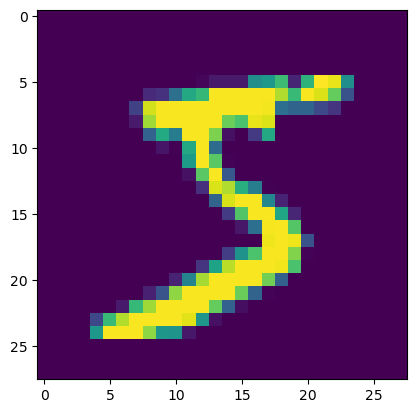

In [25]:
import matplotlib.pyplot as plt
plt.imshow(train_images[0].reshape(28, 28))

In [145]:
train_labels_one_hot[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [146]:
train_images.shape

(60000, 784)

In [147]:
# model.fit(x_inputs=[train_images], y=train_labels_one_hot, batch_size=32, epochs=1)

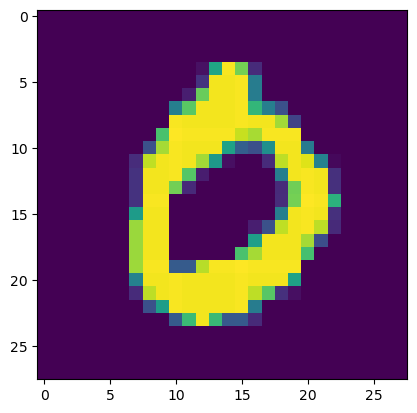

In [148]:
plt.imshow(test_images[3])

array([2], dtype=int64)

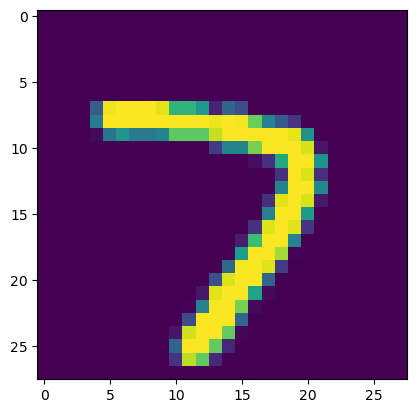

In [149]:
idx = 17
plt.imshow(test_images[idx])
np.argmax(model.predict(x_inputs=[test_images[idx].reshape(-1, 784)]), axis=-1)

In [150]:

preds = np.argmax(model.predict(x_inputs=[test_images.reshape(-1, 1, 784)]), axis=-1)

In [313]:
preds.shape

(10000, 1)

In [152]:
sum(preds.reshape(-1) == test_labels) / len(test_labels)

0.1237

In [196]:
inp = Input((28, 28, 1))
conv1 = Conv2D(num_kernals=8, activation=ReLU(), name="conv1")(inp)
conv2 = Conv2D(num_kernals=4, activation=ReLU(), name="conv2")(conv1)
flatten = Flatten(name="flatten")(conv2)
out = Dense(units=10, activation=Softmax(), name="dense")(flatten)

cnn = Model(inputs=[inp], output=out)

cnn.set_loss_function(CategoricalCrossEntropy()).set_optimizer(Adam(lr=1e-3))

cnn.summary()


(2304, 10)
------------------------------------------------------------------------------------------
|| Layer     || Shape	   || Activation		||
------------------------------------------------------------------------------------------
Layer: Input | (28, 28, 1)
------------------------------------------------------------------------------------------
Layer: Conv2D | (26, 26, 8) | <class '__main__.ReLU'>
------------------------------------------------------------------------------------------
Layer: Conv2D | (24, 24, 4) | <class '__main__.ReLU'>
------------------------------------------------------------------------------------------
Layer: Flatten | (2304,)
------------------------------------------------------------------------------------------
Layer: Dense | (10,) | <class '__main__.Softmax'>
Loss Functions: <class '__main__.CategoricalCrossEntropy'>
******************************************************************************************
Optimizer: <class '__main__.Adam'>
Total

In [208]:
inp = Input((10,))
dense1 = Dense(64, activation=ReLU(), name='dense1')(inp)
reshape = Reshape(shape=(8, 8, 1), name="reshape1")(dense1)
convT1 = Conv2DTranspose(num_kernals=4, kernal_shape=(4,4), stride=2, padding=2, activation=ReLU(), name="convT1")(reshape)
convT2 = Conv2DTranspose(num_kernals=8, kernal_shape=(4,4), stride=2, padding=2, activation=ReLU(), name="convT2")(convT1)
convT3 = Conv2DTranspose(num_kernals=1, activation=Sigmoid(), name="convT3")(convT1)

gen = Model(inputs=[inp], output=convT3)

gen.set_loss_function(CategoricalCrossEntropy()).set_optimizer(Adam(lr=1e-3))

gen.summary()


(10, 64)
["reshape_260f9"].reshape
ReLU["max_5ef0a"].max
ReLU["max_5ef0a"].max
------------------------------------------------------------------------------------------
|| Layer     || Shape	   || Activation		||
------------------------------------------------------------------------------------------
Layer: Input | (10,)
------------------------------------------------------------------------------------------
Layer: Dense | (64,) | <class '__main__.ReLU'>
------------------------------------------------------------------------------------------
Layer: Reshape | (8, 8, 1)
------------------------------------------------------------------------------------------
Layer: Conv2DTranspose | (14, 14, 4) | <class '__main__.ReLU'>
------------------------------------------------------------------------------------------
Layer: Conv2DTranspose | (16, 16, 1) | <class '__main__.Sigmoid'>
Loss Functions: <class '__main__.CategoricalCrossEntropy'>
*************************************************

In [209]:
(8 - 1) * 2 - 4 + 4

14

In [210]:
gen.predict([np.random.rand(1, 10)])

--> INPUT["var_38e2c"].var (1, 10)
--> dense1.W["var_1fc65"].var{param} (10, 64)
--> ["@_c138e"].@ (1, 64)
--> dense1.b["var_b260f"].var{param} (1, 64)
--> ["+_0d4a8"].+ (1, 64)
--> ReLU["max_db851"].max (1, 64)
--> ["reshape_260f9"].reshape (1, 8, 8, 1)
--> convT1["im2col_55e87"].im2col (1, 25, 16)
--> ["var_581eb"].var{param} (4, 16)
--> ["T_4dab1"].T (16, 4)
--> ["@_6d35a"].@ (1, 25, 4)
--> ["var_342cf"].var{param} (1, 4)
--> ["+_c9402"].+ (1, 25, 4)


ValueError: cannot reshape array of size 100 into shape (1,8,8,4,4,4)

In [197]:
imm = im2col(np.ones((1,8,8,1)), kernal_shape=(4,4), stride=2, padding=2)

In [198]:
4*4*4*8*8

4096

In [199]:
imm.shape

(1, 25, 16)

In [200]:
(imm @ np.ones((16, 4))).shape

(1, 25, 4)

In [201]:
# cnn2 = load_model('./cnn')

In [202]:
# cnn2.summary()

In [203]:
print("number of parameters:", '{:,}'.format(cnn.total_parameter_count()))

number of parameters: 23,422


In [204]:
train_images.reshape((-1, 28, 28, 1)).shape

(60000, 28, 28, 1)

In [205]:
cnn.fit(
    x_inputs=[train_images.reshape((-1, 28, 28, 1))],
    y=train_labels_one_hot,
    x_val_inputs=[test_images.reshape((-1, 28, 28, 1))],
    y_val=test_labels_one_hot,
    batch_size=32,
    epochs=1
)

X.shape: (1875, 32, 28, 28, 1)
y.shape: (1875, 32, 10)
Epochs: 1/1
--> INPUT["var_34a37"].var (32, 28, 28, 1)
--> ["im2col_d236c"].im2col (32, 676, 9)
--> ["var_e6774"].var{param} (9, 8)
--> ["@_2402b"].@ (32, 676, 8)
--> ["var_65199"].var{param} (1, 8)
--> ["+_ac33c"].+ (32, 676, 8)
--> ["reshape_ce1b8"].reshape (32, 26, 26, 8)
--> ReLU["max_eebd4"].max (32, 26, 26, 8)
--> ["im2col_241f7"].im2col (32, 576, 72)
--> ["var_01aad"].var{param} (72, 4)
--> ["@_be240"].@ (32, 576, 4)
--> ["var_4964e"].var{param} (1, 4)
--> ["+_f4c58"].+ (32, 576, 4)
--> ["reshape_bc5eb"].reshape (32, 24, 24, 4)
--> ReLU["max_3d971"].max (32, 24, 24, 4)
--> ["reshape_9943c"].reshape (32, 2304)
--> dense.W["var_edb8a"].var{param} (2304, 10)
--> ["@_41f7a"].@ (32, 10)
--> dense.b["var_67fe5"].var{param} (1, 10)
--> ["+_230c0"].+ (32, 10)
--> softmax["max_849ad"].max (32, 1)
--> ["-_1afbd"].- (32, 10)
--> softmax["exp_b7e3d"].exp (32, 10)
--> dense["sum_6b482"].sum (32, 1)
--> ["/_da973"]./ (32, 10)
--> INPUT["v

KeyboardInterrupt: 

In [156]:
cnn.layers[0].get_params()

[]

In [157]:
preds = np.argmax(cnn.predict(x_inputs=[test_images.reshape((-1, 28, 28, 1))]), axis=-1)

In [159]:
sum(preds.reshape(-1) == test_labels) / len(test_labels)

0.9525

In [160]:
cnn.save("cnn")

Saved model in path: cnn


In [161]:
cnn.get_keyed_params()

{'Input.input_1': [],
 'Conv2D.conv2d_1': [array([[-4.14987277e-01,  1.66954494e-02, -3.18682316e-01,
           4.58246510e-01,  9.28860296e-01, -1.11973804e-01,
           2.27130842e-01, -6.00802991e-01],
         [ 3.36810407e-01, -1.01914966e-01, -3.01498125e-01,
           5.04604789e-02, -1.80432371e-01,  4.81437039e-01,
          -4.43084791e-01, -1.08561428e+00],
         [ 3.65973699e-01,  8.74387152e-02, -3.75654300e-01,
           6.33069073e-01, -4.80175701e-02,  4.90448463e-02,
          -2.21734968e-01, -4.58898592e-01],
         [-4.67391134e-01, -9.91884581e-02, -6.75730041e-01,
          -6.66161103e-01, -3.06925039e-01,  2.31177532e-01,
           1.35807095e-01, -1.86729910e-01],
         [ 1.72535512e-01, -1.68495363e-01, -3.01343121e-01,
          -9.01372411e-01, -7.94373061e-01, -2.90278000e-01,
          -2.06336872e-01,  4.72151961e-01],
         [-2.01522569e-01,  3.24261383e-01, -8.14237631e-01,
          -6.30594130e-01,  1.97062000e-01, -6.09408730e-01,
  

In [162]:
cnn.layers[1].get_params()

[array([[-4.14987277e-01,  1.66954494e-02, -3.18682316e-01,
          4.58246510e-01,  9.28860296e-01, -1.11973804e-01,
          2.27130842e-01, -6.00802991e-01],
        [ 3.36810407e-01, -1.01914966e-01, -3.01498125e-01,
          5.04604789e-02, -1.80432371e-01,  4.81437039e-01,
         -4.43084791e-01, -1.08561428e+00],
        [ 3.65973699e-01,  8.74387152e-02, -3.75654300e-01,
          6.33069073e-01, -4.80175701e-02,  4.90448463e-02,
         -2.21734968e-01, -4.58898592e-01],
        [-4.67391134e-01, -9.91884581e-02, -6.75730041e-01,
         -6.66161103e-01, -3.06925039e-01,  2.31177532e-01,
          1.35807095e-01, -1.86729910e-01],
        [ 1.72535512e-01, -1.68495363e-01, -3.01343121e-01,
         -9.01372411e-01, -7.94373061e-01, -2.90278000e-01,
         -2.06336872e-01,  4.72151961e-01],
        [-2.01522569e-01,  3.24261383e-01, -8.14237631e-01,
         -6.30594130e-01,  1.97062000e-01, -6.09408730e-01,
         -3.20842978e-03, -1.09641625e-01],
        [ 3.1705

In [66]:
loaded_cnn = load_model("cnn")

(2304, 10)


In [67]:
loaded_cnn.get_keyed_params()

{'Input.input_1': [],
 'Conv2D.conv2d_1': [array([[-4.14987277e-01,  1.66954494e-02, -3.18682316e-01,
           4.58246510e-01,  9.28860296e-01, -1.11973804e-01,
           2.27130842e-01, -6.00802991e-01],
         [ 3.36810407e-01, -1.01914966e-01, -3.01498125e-01,
           5.04604789e-02, -1.80432371e-01,  4.81437039e-01,
          -4.43084791e-01, -1.08561428e+00],
         [ 3.65973699e-01,  8.74387152e-02, -3.75654300e-01,
           6.33069073e-01, -4.80175701e-02,  4.90448463e-02,
          -2.21734968e-01, -4.58898592e-01],
         [-4.67391134e-01, -9.91884581e-02, -6.75730041e-01,
          -6.66161103e-01, -3.06925039e-01,  2.31177532e-01,
           1.35807095e-01, -1.86729910e-01],
         [ 1.72535512e-01, -1.68495363e-01, -3.01343121e-01,
          -9.01372411e-01, -7.94373061e-01, -2.90278000e-01,
          -2.06336872e-01,  4.72151961e-01],
         [-2.01522569e-01,  3.24261383e-01, -8.14237631e-01,
          -6.30594130e-01,  1.97062000e-01, -6.09408730e-01,
  

In [68]:
loaded_cnn.summary()

------------------------------------------------------------------------------------------
|| Layer     || Shape	   || Activation		||
------------------------------------------------------------------------------------------
Layer: Input | [28, 28, 1]
------------------------------------------------------------------------------------------
Layer: Conv2D | (26, 26, 8) | <class '__main__.ReLU'>
------------------------------------------------------------------------------------------
Layer: Conv2D | (24, 24, 4) | <class '__main__.ReLU'>
------------------------------------------------------------------------------------------
Layer: Flatten | (2304,)
------------------------------------------------------------------------------------------
Layer: Dense | (10,) | <class '__main__.Softmax'>
Loss Functions: <class '__main__.CategoricalCrossEntropy'>
******************************************************************************************
Optimizer: <class '__main__.Adam'>
Total number of 

In [69]:
preds = np.argmax(loaded_cnn.predict(x_inputs=[test_images.reshape((-1, 28, 28, 1))]), axis=-1)
sum(preds.reshape(-1) == test_labels) / len(test_labels)

--> INPUT["var_9e8c7"].var (10000, 28, 28, 1)
--> ["pad_08c0b"].pad (10000, 28, 28, 1)
--> ["im2col_77f7f"].im2col (10000, 676, 9)
--> ["var_78ed2"].var{param} (9, 8)
--> ["@_659b9"].@ (10000, 676, 8)
--> ["var_3d451"].var{param} (1, 8)
--> ["+_4f9c2"].+ (10000, 676, 8)
--> ["reshape_a4451"].reshape (10000, 26, 26, 8)
--> ReLU["max_65844"].max (10000, 26, 26, 8)
--> ["pad_26ee1"].pad (10000, 26, 26, 8)
--> ["im2col_6bb78"].im2col (10000, 576, 72)
--> ["var_d5672"].var{param} (72, 4)
--> ["@_89344"].@ (10000, 576, 4)
--> ["var_39246"].var{param} (1, 4)
--> ["+_9bf38"].+ (10000, 576, 4)
--> ["reshape_7b5c2"].reshape (10000, 24, 24, 4)
--> ReLU["max_77f24"].max (10000, 24, 24, 4)
--> ["reshape_6ad0d"].reshape (10000, 2304)
--> dense.W["var_54539"].var{param} (2304, 10)
--> ["@_2a66b"].@ (10000, 10)
--> dense.b["var_e7262"].var{param} (1, 10)
--> ["+_e55c2"].+ (10000, 10)
--> softmax["max_98ceb"].max (10000, 1)
--> ["-_bc869"].- (10000, 10)
--> softmax["exp_2d533"].exp (10000, 10)
--> dens

0.9525

In [168]:
test_images[idx].reshape((-1, *test_images[idx].shape,1)).shape

(1, 28, 28, 1)

array([6], dtype=int64)

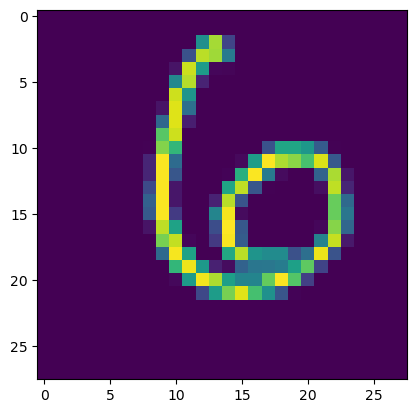

In [170]:
idx = 100
plt.imshow(test_images[idx])
np.argmax(cnn.predict(x_inputs=[test_images[idx].reshape((-1, *test_images[idx].shape,1))]), axis=-1)

In [171]:
x = OpNode("var")
y = OpNode("ln")(OpNode("cos")(x * x)) + OpNode("sin")(x)
y.vars

[["ln_ff917"].ln, ["sin_7f1c1"].sin]

In [172]:
x_sub = 1

x.substitute(x_sub)

ordered_operations, _ = topological_DFS(y)

for op in ordered_operations:
    op.compute()
    print(op, ":", op.val)

print("-"*50)
print(func(x_sub))

["var_d94b0"].var : 1
["const_40aa2"].const : 2
["**_87455"].** : 1
["cos_2e8cd"].cos : 0.5403023058681398
["ln_ff917"].ln : -0.6156264703860141
["sin_7f1c1"].sin : 0.8414709848078965
["+_80ae7"].+ : 0.22584451442188236
--------------------------------------------------
0.22584451442188236


In [173]:
for op in reversed(ordered_operations):
    op.adjoint = None
    op.compute_adjoint()
    print(f"[{op}] adjoint:", op.adjoint)
    print("---------------------")

print("="*50)
print(d_func(x_sub))

[["+_80ae7"].+] adjoint: 1
---------------------
[["sin_7f1c1"].sin] adjoint: 1
---------------------
[["ln_ff917"].ln] adjoint: 1
---------------------
[["cos_2e8cd"].cos] adjoint: 1.850781463126706
---------------------
[["**_87455"].**] adjoint: -1.557378900441429
---------------------
[["const_40aa2"].const] adjoint: 0.0
---------------------
[["var_d94b0"].var] adjoint: -2.574455495014718
---------------------
-2.5745131434416644


In [174]:
(2 * OpNode("var")).vars

[["const_7ed68"].const, ["var_10a2f"].var]

In [175]:
x1 = OpNode("var")
x2 = OpNode("var")
y_ = OpNode("ln")(OpNode("cos")(x1 * x2)) + OpNode("sin")(x1) + 2 * x2

y_.vars, y_.leafs

([["+_26667"].+, ["*_b0d25"].*], [])

In [176]:
topological_DFS(y_)

([["var_a84cf"].var,
  ["var_ef9d3"].var,
  ["*_67cb4"].*,
  ["cos_19eb6"].cos,
  ["ln_1a718"].ln,
  ["sin_8eecf"].sin,
  ["+_26667"].+,
  ["const_a32e4"].const,
  ["*_b0d25"].*,
  ["+_51a41"].+],
 [5, 5, 4, 3, 2, 2, 1, 2, 1, 0])

In [177]:
x1.substitute(5)
x2.substitute(9)

for op in DFS(y_):
    # print(op)
    op.compute()
    print(op, ":", op.val)

["var_a84cf"].var : 5
["var_ef9d3"].var : 9
["*_67cb4"].* : 45
["cos_19eb6"].cos : 0.5253219888177297
["ln_1a718"].ln : -0.6437438923557037
["var_a84cf"].var : 5
["sin_8eecf"].sin : -0.9589242746631385
["+_26667"].+ : -1.6026681670188423
["const_a32e4"].const : 2
["var_ef9d3"].var : 9
["*_b0d25"].* : 18
["+_51a41"].+ : 16.39733183298116


In [178]:

DFS(y_)[7].vars, DFS(y_)[7].vars[0].val, DFS(y_)[7].vars[1].val

([["ln_1a718"].ln, ["sin_8eecf"].sin],
 -0.6437438923557037,
 -0.9589242746631385)

In [12]:
DFS(y_)[2].leafs

[cos_f7e(cos)]

In [13]:
xx1 = 5
xx2 = 9

ln(cos(xx1 * xx2)) + sin(xx1) + 2 * xx2

16.39733183298116

In [108]:
x.substitute(5)
x.val

5

In [179]:
import networkx as nx
import matplotlib.pyplot as plt

def extract_edges(node, visited=None):
    if visited is None:
        visited = set()
    edges = []
    if node in visited:
        return edges
    visited.add(node)
    for leaf in node.vars:
        lim = len(node.op) + 5
        name = node.name[:lim]
        l_lim = len(leaf.op) + 5
        l_name = leaf.name[:l_lim]
        edges.append((name, l_name))
        edges.extend(extract_edges(leaf, visited))
    return edges

In [182]:
import networkx as nx

def remove_cycles(edges):
    # Create a directed graph from the list of edges
    G = nx.DiGraph(edges)

    try:
        # Find a cycle in the graph
        cycle = nx.find_cycle(G, orientation='original')
        while cycle:
            # Remove one edge from the cycle (use source and target nodes only)
            G.remove_edge(cycle[0][0], cycle[0][1])
            print(f"Removed edge: {cycle[0][0]} -> {cycle[0][1]}")
            # Try to find another cycle
            cycle = nx.find_cycle(G, orientation='original')
    except nx.exception.NetworkXNoCycle:
        pass

    return G

def no_cycle_graph(G):
    G = nx.DiGraph(list(G.edges))
    try:
        # Find a cycle in the graph
        cycle = nx.find_cycle(G, orientation='original')
        while cycle:
            # Remove one edge from the cycle (use source and target nodes only)
            G.remove_edge(cycle[0][0], cycle[0][1])
            print(f"Removed edge: {cycle[0][0]} -> {cycle[0][1]}")
            # Try to find another cycle
            cycle = nx.find_cycle(G, orientation='original')
    except nx.exception.NetworkXNoCycle:
        pass

    return G

# Remove cycles
G = remove_cycles(edges)

# Print the edges of the resulting DAG
print("Edges of the resulting DAG:")
print(len(list(G.edges)))



NameError: name 'edges' is not defined

Is the graph a DAG? True


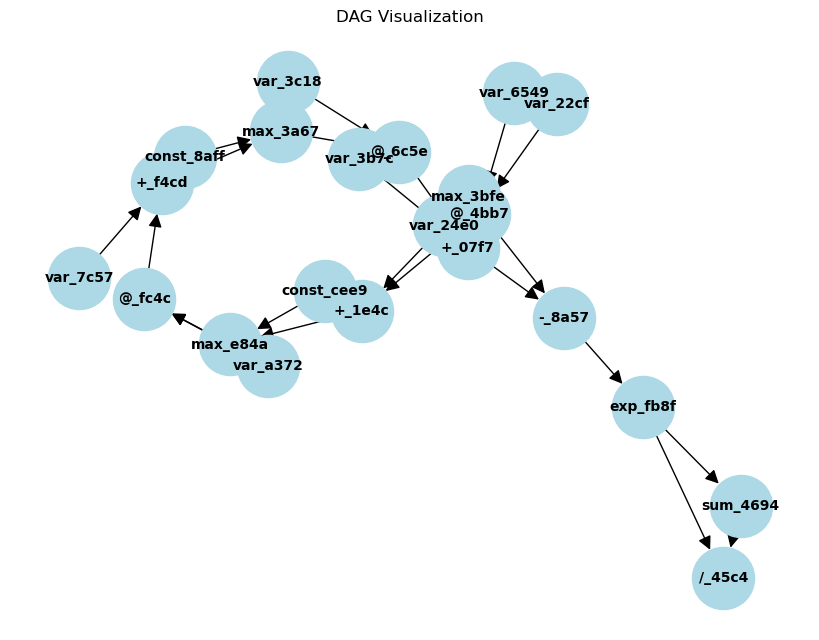

In [183]:
edges = extract_edges(model.output.get_output_node_())

# Create a directed graph using networkx
G = nx.DiGraph(directed=True)
G.add_edges_from(edges)
G_reversed = G.reverse(copy=False)
G_reversed = no_cycle_graph(G_reversed)

is_dag = nx.is_directed_acyclic_graph(G_reversed)
print("Is the graph a DAG?", is_dag)

pos = nx.spring_layout(G_reversed)
# Draw the graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G_reversed)  # You can change this to other layouts like nx.shell_layout, etc.
nx.draw(G_reversed, pos, with_labels=True, node_size=2000, node_color="lightblue", font_size=10, font_weight="bold", arrowsize=20)
plt.title("DAG Visualization")
plt.show()

In [185]:
# def draw_dag_sequentially(G):
#     G = no_cycle_graph(G)
#     pos = nx.spring_layout(G)
#     plt.figure(figsize=(10, 8))
#     nodes_in_topological_order = list(nx.topological_sort(G))

#     for i in range(len(nodes_in_topological_order)):
#         subgraph_nodes = nodes_in_topological_order[:i + 1]
#         subgraph = G.subgraph(subgraph_nodes)

#         plt.clf()  # Clear the current plot
#         nx.draw(subgraph, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=15, font_weight="bold", arrows=True)
#         plt.title(f"DAG - Step {i + 1}")
#         plt.pause(1)  # Pause to display each step

#     plt.show()

# # Draw the DAG sequentially
# draw_dag_sequentially(G_reversed)


In [ ]:
for op, _ in ordered_operations:
    op.compute()
    print(op.val)

5
5
25
0.9912028118634736
-0.008836111843672067
5
-0.9589242746631385
0.9677603865068105
